In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [155]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.impute import SimpleImputer
from scipy.stats import mstats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import missingno as msno

In [156]:
data = pd.read_csv("dataset_mood_smartphone.csv", index_col=0)              # Load the data                                                    

In [157]:
data.tail(), data.columns

(              id                     time        variable   value
 2770399  AS14.30  2014-04-11 07:51:16.948  appCat.weather   8.032
 2772465  AS14.30  2014-04-19 11:00:32.747  appCat.weather   3.008
 2774026  AS14.30  2014-04-26 10:19:07.434  appCat.weather   7.026
 2774133  AS14.30  2014-04-27 00:44:48.450  appCat.weather  23.033
 2784435  AS14.32  2014-04-07 18:25:14.036  appCat.weather  22.431,
 Index(['id', 'time', 'variable', 'value'], dtype='object'))

In [158]:
# Pivot the dataset to have each variable as a column
data_pivoted = data.pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc='first').reset_index()

# Show the transformed data
data_pivoted.head()

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,AS14.01,2014-02-17 12:04:42.394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-17 18:28:25.520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-18 09:29:51.257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,AS14.01,2014-02-19 14:43:30.575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,AS14.01,2014-02-19 17:29:10.378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [159]:
# Dataset summary
summary = {
    "Number of Records": len(data_pivoted),
    "Number of Attributes": len(data_pivoted.columns),
    "Attribute Types": data_pivoted.dtypes,
    "Missing Values": data_pivoted.isnull().sum(),
    "Range of Numeric Values": data_pivoted.describe().loc[['min', 'max']],
}

#print(summary)


In [160]:
summary

{'Number of Records': 358926,
 'Number of Attributes': 21,
 'Attribute Types': variable
 id                       object
 time                     object
 activity                float64
 appCat.builtin          float64
 appCat.communication    float64
 appCat.entertainment    float64
 appCat.finance          float64
 appCat.game             float64
 appCat.office           float64
 appCat.other            float64
 appCat.social           float64
 appCat.travel           float64
 appCat.unknown          float64
 appCat.utilities        float64
 appCat.weather          float64
 call                    float64
 circumplex.arousal      float64
 circumplex.valence      float64
 mood                    float64
 screen                  float64
 sms                     float64
 dtype: object,
 'Missing Values': variable
 id                           0
 time                         0
 activity                335961
 appCat.builtin          267638
 appCat.communication    284650
 appCat.enterta

In [161]:
data_pivoted.describe()

variable,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
count,22965.000000,91288.000000,74276.000000,27125.000000,939.000000,813.000000,5642.000000,7650.000000,19145.000000,2846.000000,939.000000,2487.000000,255.000000,5239.0,5582.000000,5474.000000,5628.000000,96578.000000,1798.0
mean,0.115958,18.538262,43.343792,37.576480,21.755251,128.391615,22.578892,25.810839,72.401906,45.730850,45.553006,18.537552,20.148714,1.0,-0.097635,0.689258,6.993959,75.335206,1.0
std,0.186946,415.989243,128.912750,262.960476,39.218361,327.145246,449.601382,112.781355,261.551846,246.109307,119.400405,60.959134,24.943431,0.0,1.051427,0.670218,1.031906,253.822497,0.0
min,0.000000,-82798.871000,0.006000,-0.011000,0.131000,1.003000,0.003000,0.014000,0.094000,0.080000,0.111000,0.246000,1.003000,1.0,-2.000000,-2.000000,1.000000,0.035000,1.0
25%,0.000000,2.020000,5.218000,1.334000,4.072000,14.148000,2.004000,7.019000,9.030000,5.086500,5.018000,3.158500,8.684000,1.0,-1.000000,0.000000,7.000000,5.322250,1.0
50%,0.021739,4.038000,16.225500,3.391000,8.026000,43.168000,3.106000,10.028000,28.466000,18.144000,17.190000,8.030000,15.117000,1.0,0.000000,1.000000,7.000000,20.044500,1.0
75%,0.158333,9.922000,45.475750,14.922000,20.155000,123.625000,8.043750,16.829250,75.372000,47.227250,44.430500,19.331000,25.349000,1.0,1.000000,1.000000,8.000000,62.540250,1.0
max,1.000000,33960.246000,9830.777000,32148.677000,355.513000,5491.793000,32708.818000,3892.038000,30000.906000,10452.615000,2239.937000,1802.649000,344.863000,1.0,2.000000,2.000000,10.000000,9867.007000,1.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


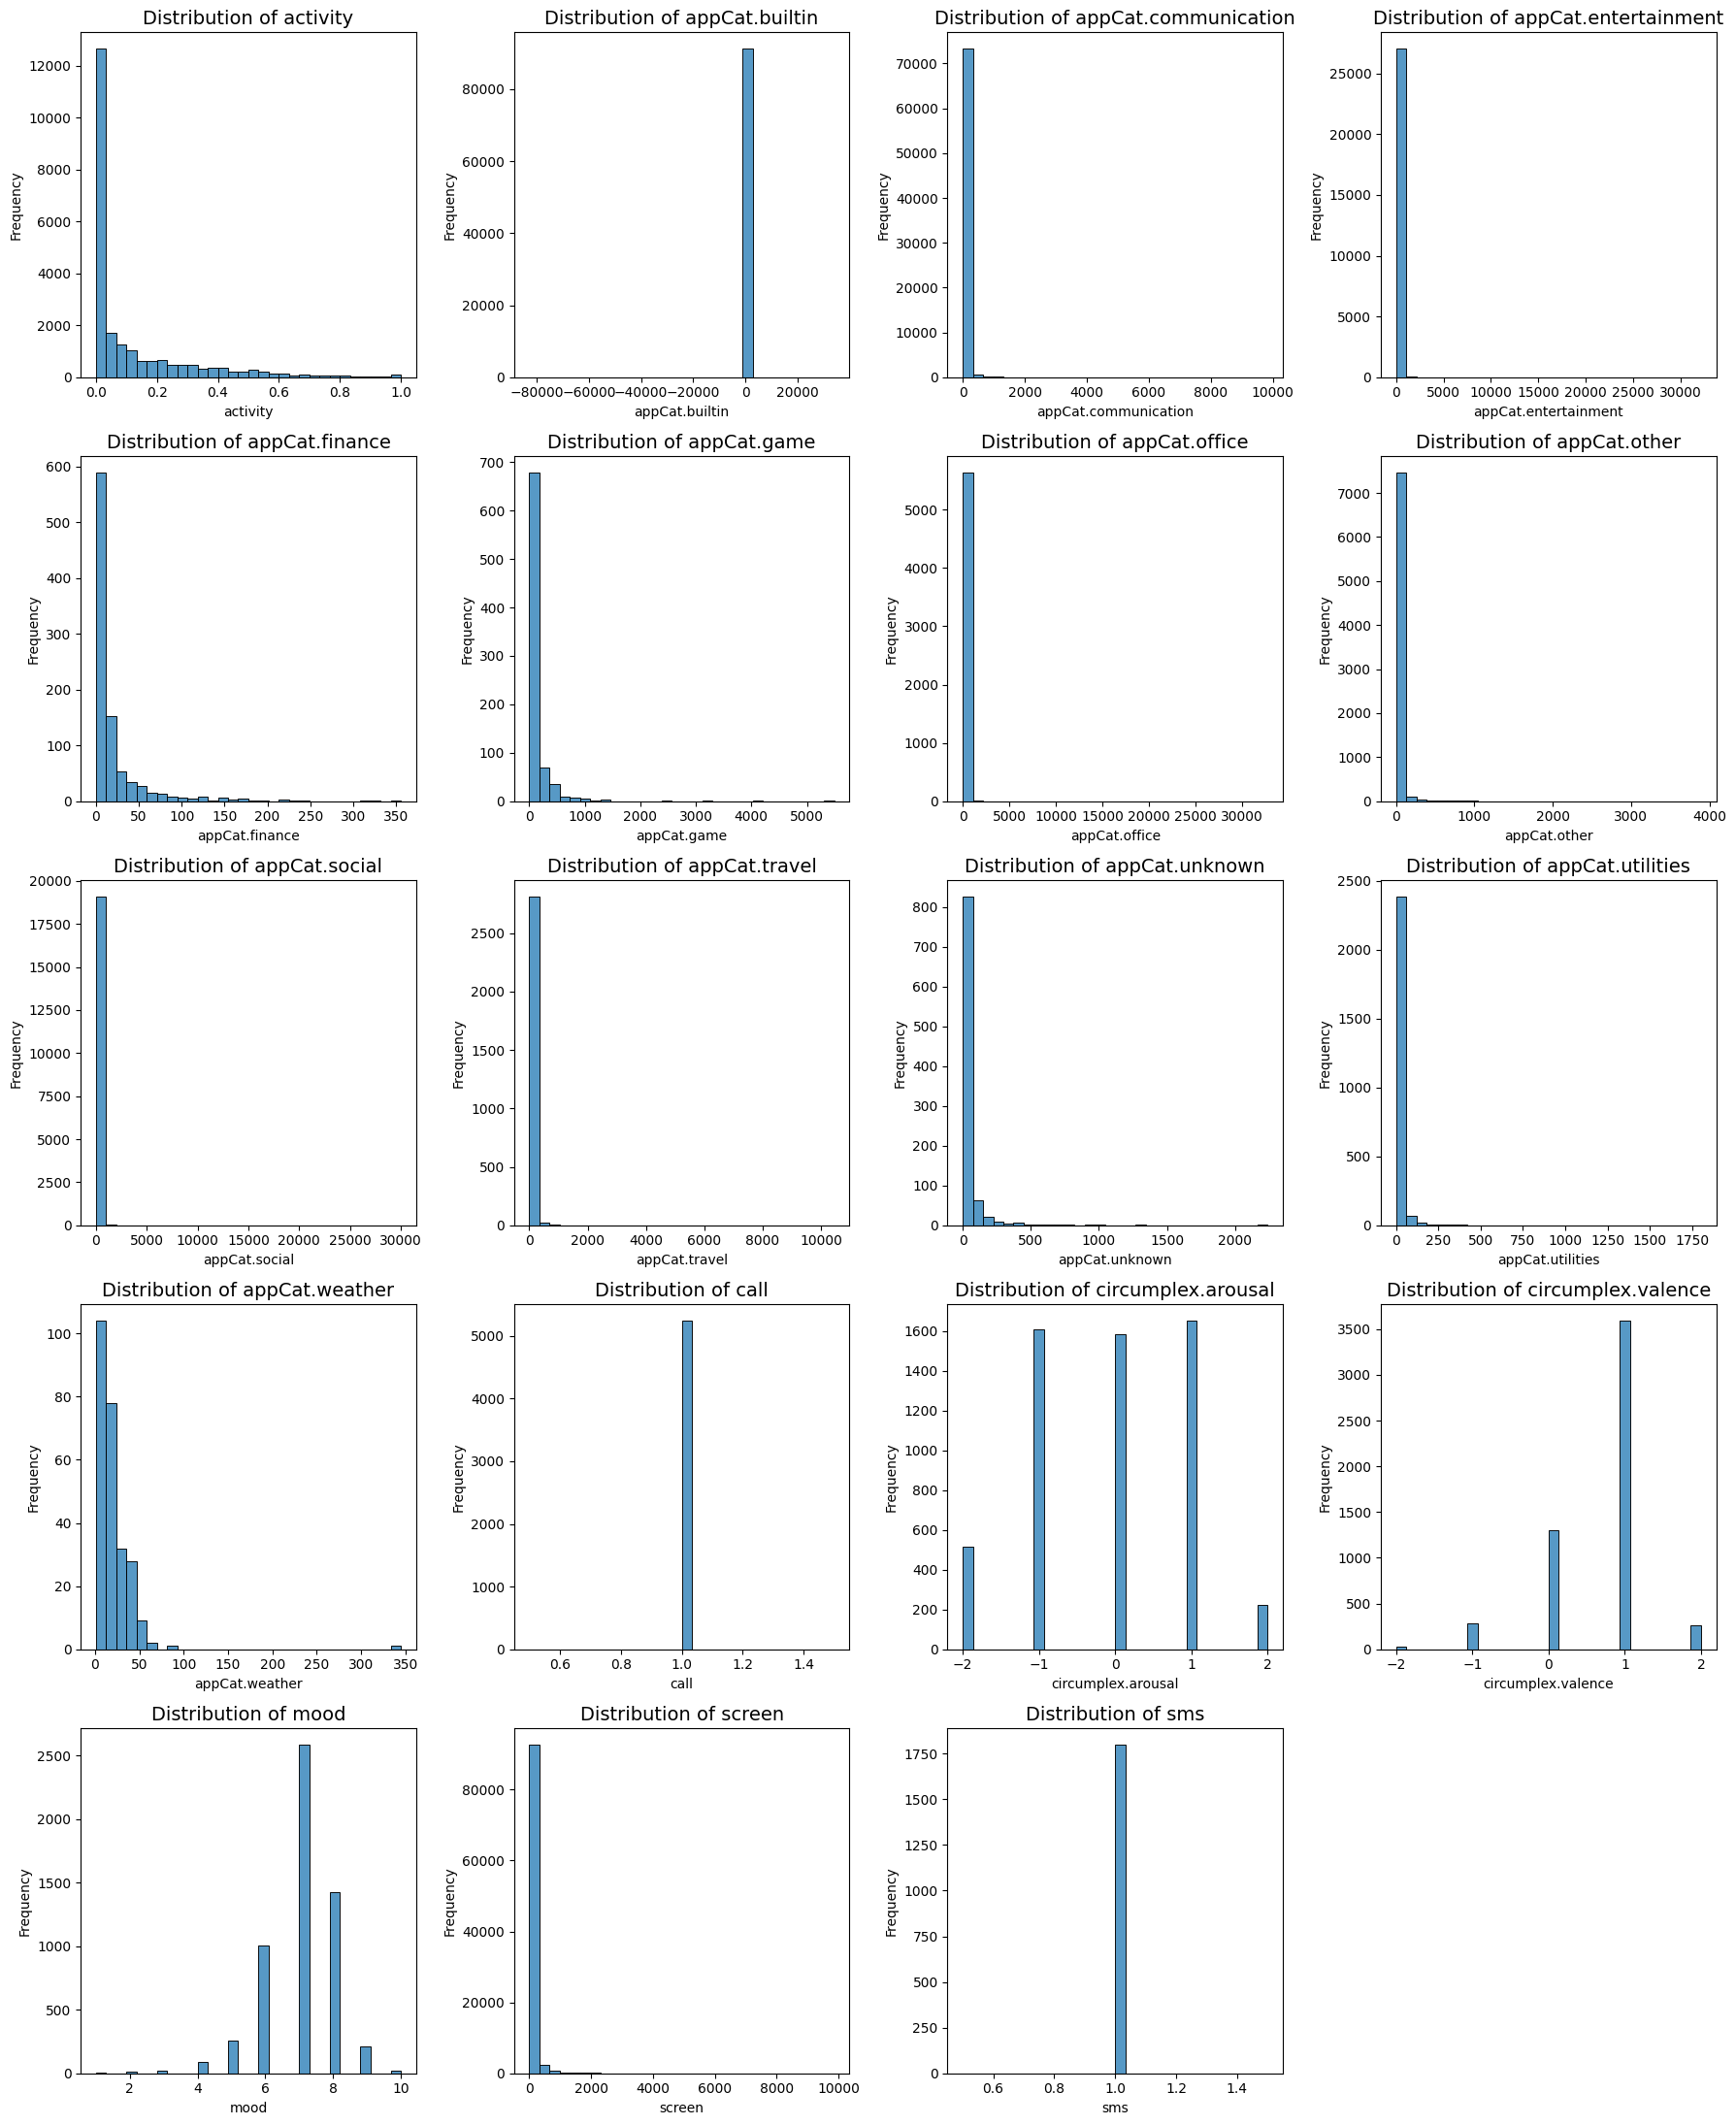

In [162]:
# Set up the figure layout to accommodate multiple plots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 22))
axes = axes.flatten()

# Plot histograms for each numeric column
for i, col in enumerate(data_pivoted.select_dtypes(include='float64').columns):
    sns.histplot(data_pivoted[col].dropna(), ax=axes[i], bins=30, kde=False)
    axes[i].set_title(f'Distribution of {col}', fontsize = 14)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("Variable_Distributions.eps", format='eps')
#plt.show()


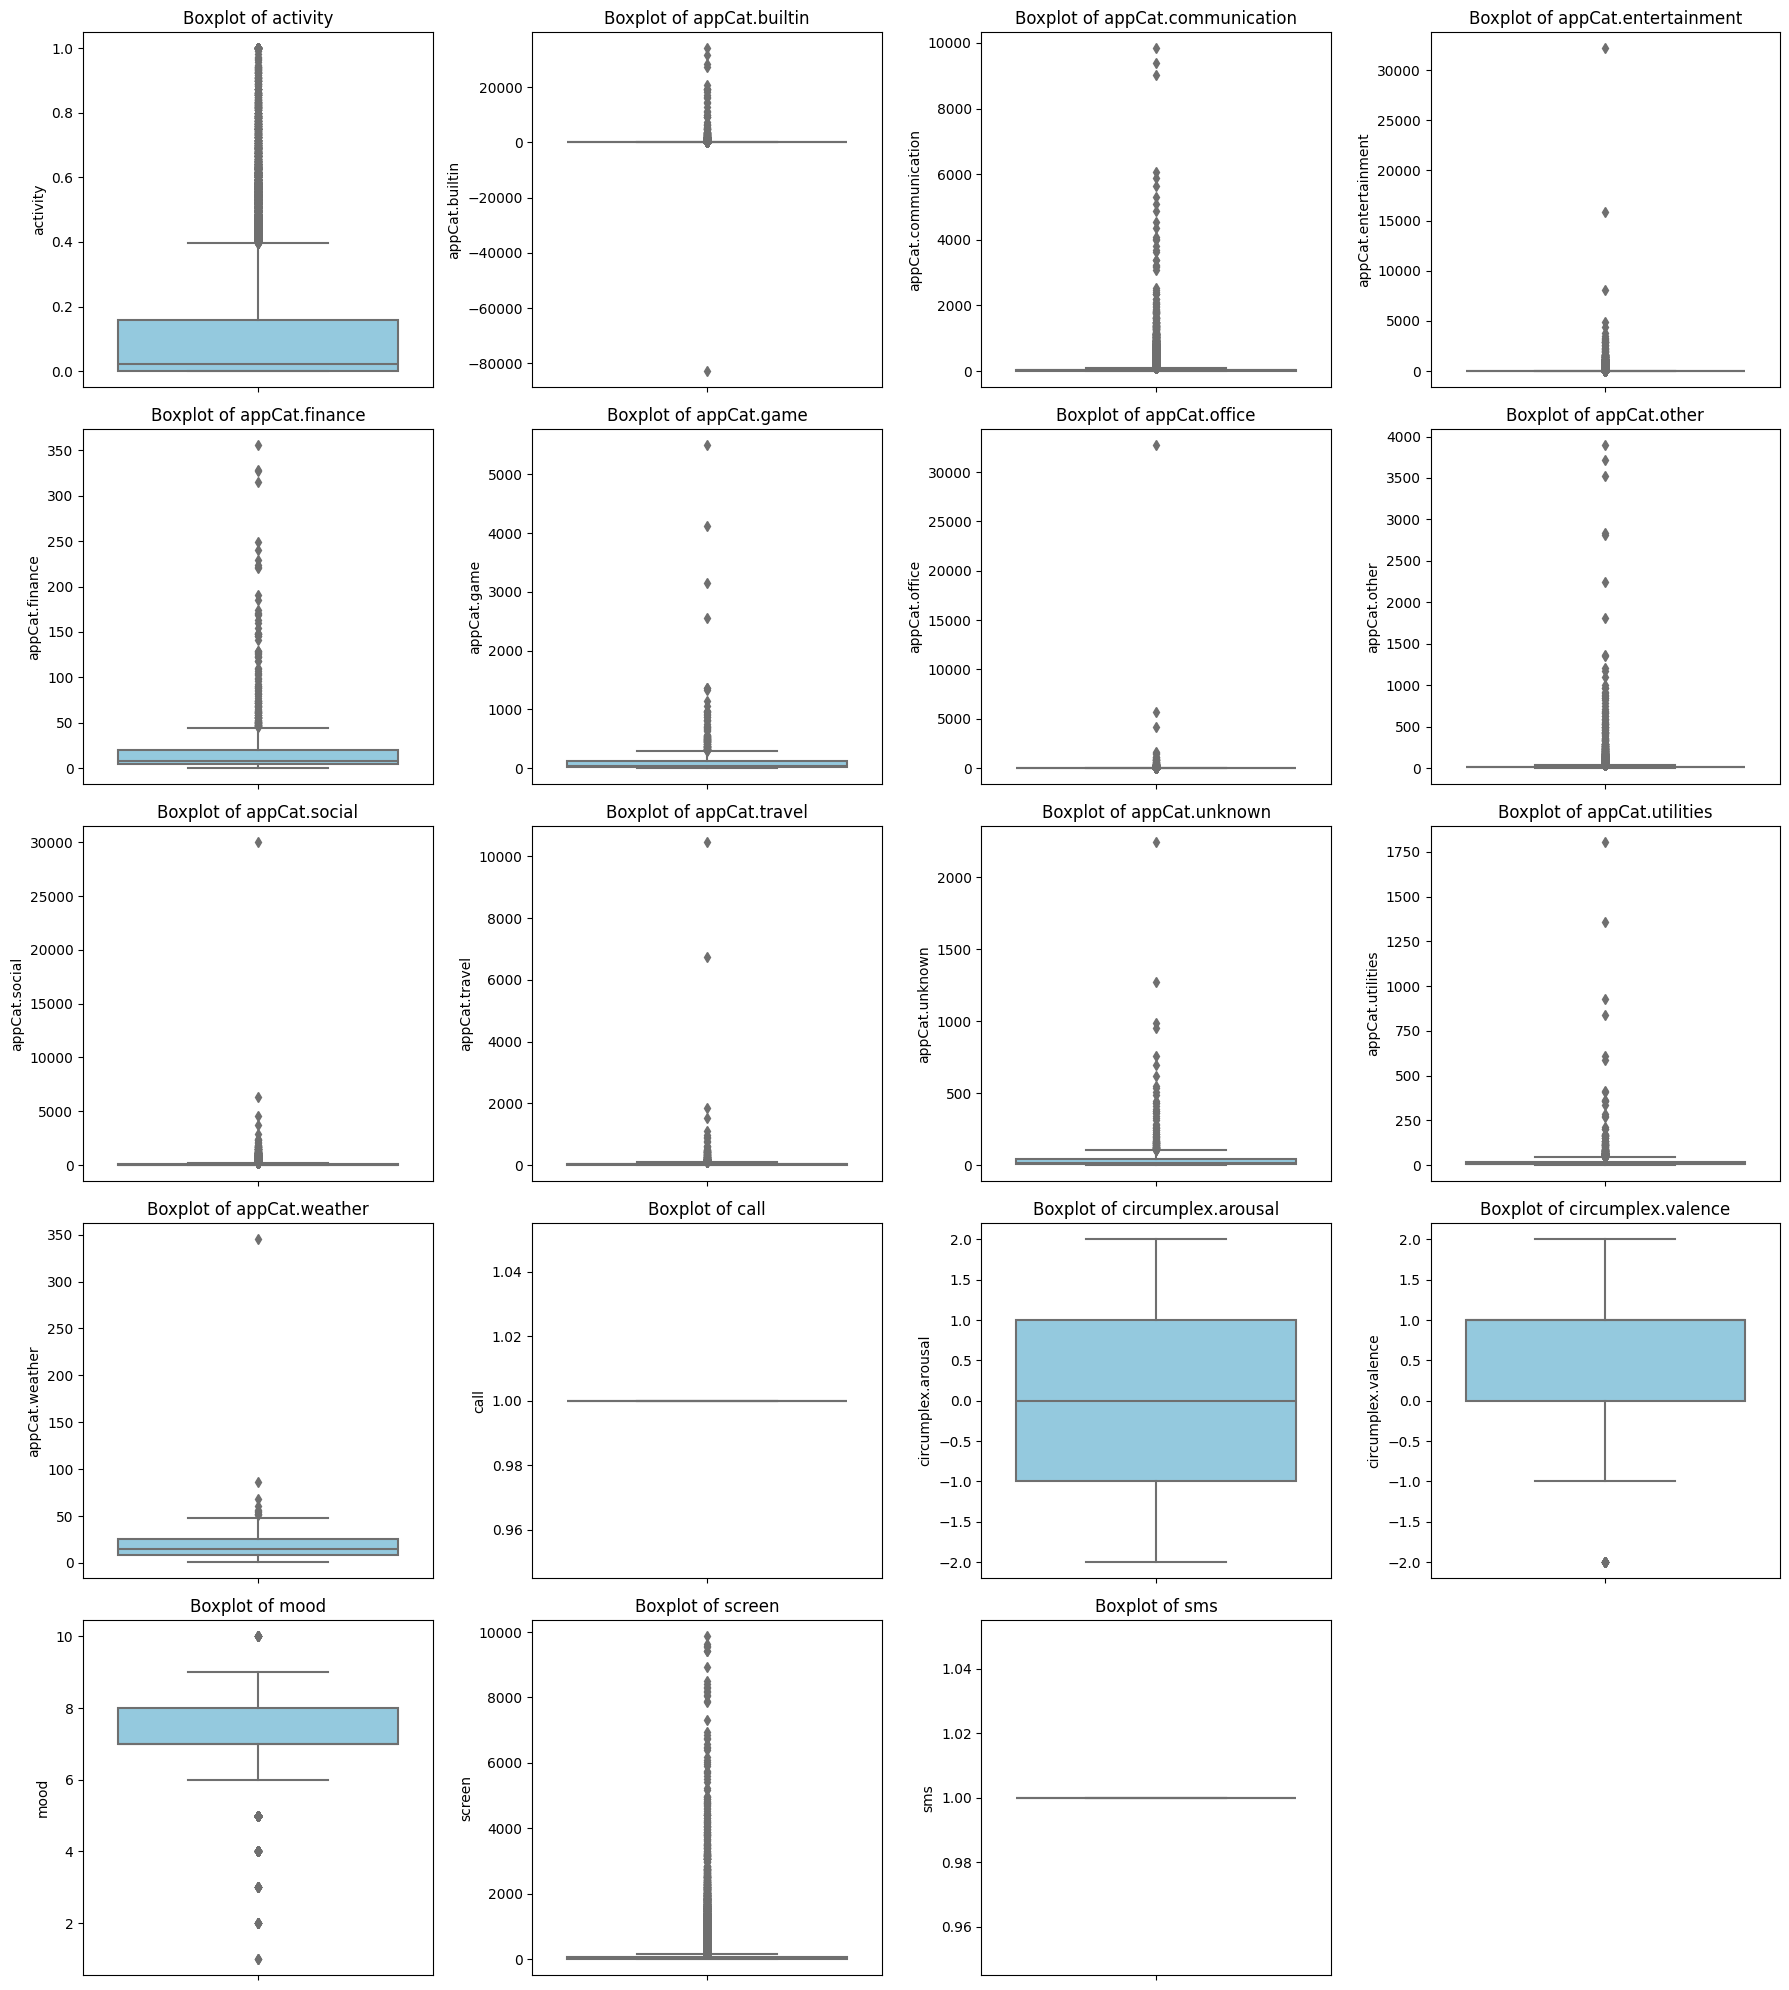

In [163]:
# Extract all numeric columns for histograms (excluding 'id' and 'time' which are not numeric)
numeric_vars = data_pivoted.select_dtypes(include=['float64', 'int64']).columns
# Set up the figure layout to accommodate multiple boxplots
fig, axes = plt.subplots(nrows=(len(numeric_vars) // 4 + (len(numeric_vars) % 4 > 0)), ncols=4, figsize=(18, 20))
axes = axes.flatten()

# Generate boxplots for each numeric column
for i, var in enumerate(numeric_vars):
    sns.boxplot(y=data_pivoted[var], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {var}')
    axes[i].set_ylabel(var)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig("Box_plot.eps", format='eps')


#### Number of Unique Users

In [164]:
# Display unique user IDs in the dataset
unique_user_ids = data_pivoted['id'].unique()
print(f"Number of unique users: {len(unique_user_ids)}")
print(f"Unique user IDs: {unique_user_ids}")

Number of unique users: 27
Unique user IDs: ['AS14.01' 'AS14.02' 'AS14.03' 'AS14.05' 'AS14.06' 'AS14.07' 'AS14.08'
 'AS14.09' 'AS14.12' 'AS14.13' 'AS14.14' 'AS14.15' 'AS14.16' 'AS14.17'
 'AS14.19' 'AS14.20' 'AS14.23' 'AS14.24' 'AS14.25' 'AS14.26' 'AS14.27'
 'AS14.28' 'AS14.29' 'AS14.30' 'AS14.31' 'AS14.32' 'AS14.33']


### Plot User Moods

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


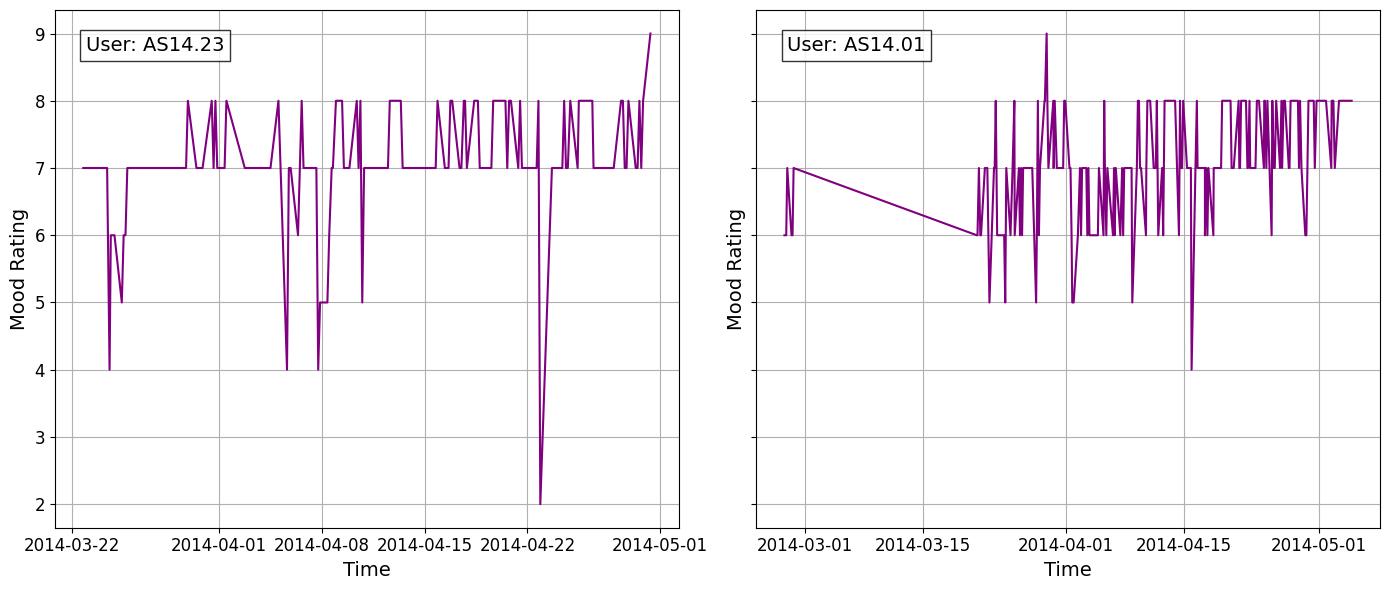

In [165]:
selected_users = ['AS14.23', 'AS14.01']

# Filter the dataset for mood measurements of the selected users and create a copy to address the warning
user_data_plots = {}
for user_id in selected_users:
    user_data = data[(data['id'] == user_id) & (data['variable'] == 'mood')].copy()
    user_data['time'] = pd.to_datetime(user_data['time'])
    user_data_sorted = user_data.sort_values('time')
    user_data_plots[user_id] = user_data_sorted
    
# Plotting mood data for the selected users
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
for i, user_id in enumerate(selected_users):
    axes[i].plot(user_data_plots[user_id]['time'], user_data_plots[user_id]['value'], linestyle='-', color='purple')
    axes[i].set_xlabel('Time', fontsize=14)  # Set xlabel with fontsize
    axes[i].set_ylabel('Mood Rating', fontsize=14)  # Set ylabel with fontsize
    axes[i].grid(True)
    
    # Set x and y-axis tick label font sizes
    axes[i].tick_params(axis='x', labelsize=12)  # Increase x-axis tick label font size
    axes[i].tick_params(axis='y', labelsize=12)  # Increase y-axis tick label font size
    
    # Annotating plot with user ID
    axes[i].text(0.05, 0.95, f'User: {user_id}', transform=axes[i].transAxes, fontsize=14, 
                 verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig("mood_user_Q1.eps", format='eps')
plt.show()




#### Outlier Analysis

In [166]:

# Function to calculate outliers using IQR
def calculate_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Calculate outliers for each variable of interest
outlier_counts = {}
outlier_percentages = {}

# List of all relevant variables including app categories
variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms',
             'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 
             'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 
             'appCat.unknown', 'appCat.utilities', 'appCat.weather']

for var in variables:
    if data_pivoted[var].dtype == 'float64' or data_pivoted[var].dtype == 'int64':
        outliers = calculate_outliers(data_pivoted[var].dropna())
        outlier_counts[var] = len(outliers)
        outlier_percentages[var] = (len(outliers) / len(data_pivoted[var].dropna())) * 100

# Create a DataFrame to summarize the outlier analysis
outlier_summary = pd.DataFrame({
    "Variable": outlier_counts.keys(),
    "Number of Outliers": outlier_counts.values(),
    "Percentage of Outliers": outlier_percentages.values()
})

outlier_summary.sort_values(by='Percentage of Outliers', ascending=False)


,Variable,Number of Outliers,Percentage of Outliers
9,appCat.entertainment,4517,16.652535
12,appCat.office,848,15.030131
13,appCat.other,1000,13.071895
10,appCat.finance,118,12.566560
7,appCat.builtin,10152,11.120848
11,appCat.game,85,10.455105
4,screen,10055,10.411274
3,activity,2223,9.679948
14,appCat.social,1838,9.600418
8,appCat.communication,6401,8.617858


In [167]:
# List of all relevant variables including app categories
variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms',
             'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 
             'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 
             'appCat.unknown', 'appCat.utilities', 'appCat.weather']
# Calculate the type of value, range, and number of missing values for each variable
attribute_info = {
    'Variable': [],
    'Type of Value': [],
    'Range of Values': [],
    'Number of Missing Values': []
}

for var in variables:
    # Appending variable name
    attribute_info['Variable'].append(var)
    
    # Determining type of value and appending
    if data_pivoted[var].dtype == 'float64':
        attribute_info['Type of Value'].append('Numeric')
    elif data_pivoted[var].dtype == 'int64':
        attribute_info['Type of Value'].append('Integer')
    else:
        attribute_info['Type of Value'].append('Categorical')
    
    # Calculating and appending range of values for numeric variables
    if data_pivoted[var].dtype == 'float64' or data_pivoted[var].dtype == 'int64':
        min_val = data_pivoted[var].min()
        max_val = data_pivoted[var].max()
        attribute_info['Range of Values'].append(f"{min_val} to {max_val}")
    else:
        attribute_info['Range of Values'].append("N/A")
    
    # Counting and appending number of missing values
    missing_count = data_pivoted[var].isna().sum()
    attribute_info['Number of Missing Values'].append(missing_count)

# Convert to DataFrame for easier LaTeX conversion
attribute_info_df = pd.DataFrame(attribute_info)
attribute_info_df


,Variable,Type of Value,Range of Values,Number of Missing Values
0,mood,Numeric,1.0 to 10.0,353298
1,circumplex.arousal,Numeric,-2.0 to 2.0,353344
2,circumplex.valence,Numeric,-2.0 to 2.0,353452
3,activity,Numeric,0.0 to 1.0,335961
4,screen,Numeric,0.0350000858306885 to 9867.00699996948,262348
5,call,Numeric,1.0 to 1.0,353687
6,sms,Numeric,1.0 to 1.0,357128
7,appCat.builtin,Numeric,-82798.871 to 33960.246,267638
8,appCat.communication,Numeric,0.006 to 9830.777,284650
9,appCat.entertainment,Numeric,-0.011 to 32148.677,331801


In [168]:
# Check for negative values in each column
data_b = data_pivoted.drop(columns=['id', 'time'])
negative_values = data_b.lt(0)

# Sum up the occurrences of negative values in each column
negative_counts = negative_values.sum()

# Print columns with negative values
print("Columns with negative values:")
print(negative_counts[negative_counts > 0])

Columns with negative values:
variable
appCat.builtin             3
appCat.entertainment       1
circumplex.arousal      2126
circumplex.valence       318
dtype: int64


In [170]:
# Replacing negative values with NaN in columns where negatives are not expected
data_pivoted.loc[:, ['appCat.builtin', 'appCat.entertainment']] = data_pivoted.loc[:, ['appCat.builtin', 'appCat.entertainment']].applymap(lambda x: float('nan') if x < 0 else x)

# Checking if the replacement was successful by summarizing these columns again
data_pivoted[['appCat.builtin', 'appCat.entertainment']].describe()


variable,appCat.builtin,appCat.entertainment
count,91285.000000,27124.000000
mean,19.446411,37.577866
std,312.914956,262.965225
min,0.001000,0.001000
25%,2.020000,1.334000
50%,4.038000,3.391500
75%,9.922000,14.922250
max,33960.246000,32148.677000


In [171]:
# Convert 'time' to datetime if not already done
if data_pivoted['time'].dtype == object:
    data_pivoted['time'] = pd.to_datetime(data_pivoted['time'])

# Extract date from datetime
data_pivoted['date'] = data_pivoted['time'].dt.date

# Calculate number of unique users and dates
num_unique_users = data_pivoted['id'].nunique()
num_unique_dates = data_pivoted['date'].nunique()

num_unique_users, num_unique_dates


(27, 113)

In [172]:
# Ensure 'time' column is of datetime type
if data_pivoted['time'].dtype != 'datetime64[ns]':
    data_pivoted['time'] = pd.to_datetime(data_pivoted['time'])

# Extract date from datetime if not already done
data_pivoted['date'] = data_pivoted['time'].dt.date

# Grouping data by 'id' and 'date'
grouped_data = data_pivoted.groupby(['id', 'date']).agg({
    'mood': 'mean',  # average mood per day per user
    'screen': 'sum',  # total screen time per day per user
    'activity': 'mean',  # average activity per day per user
    'circumplex.arousal': 'mean',  # average arousal per day per user
    'circumplex.valence': 'mean',  # average valence per day per user
    'call': 'sum',  # total number of calls per day per user
    'sms': 'sum',  # total number of SMS sent per day per user
    'appCat.builtin': 'sum',  # total usage of built-in apps per day per user
    'appCat.communication': 'sum',  # total usage of communication apps per day per user
    'appCat.entertainment': 'sum',  # total usage of entertainment apps per day per user
    'appCat.finance': 'sum',  # total usage of finance apps per day per user
    'appCat.game': 'sum',  # total usage of game apps per day per user
    'appCat.office': 'sum',  # total usage of office apps per day per user
    'appCat.other': 'sum',  # total usage of other apps per day per user
    'appCat.social': 'sum',  # total usage of social apps per day per user
    'appCat.travel': 'sum',  # total usage of travel apps per day per user
    'appCat.unknown': 'sum',  # total usage of unknown apps per day per user
    'appCat.utilities': 'sum',  # total usage of utilities apps per day per user
    'appCat.weather': 'sum'  # total usage of weather apps per day per user
    # Add other variables as needed
})

# Resetting index if you want 'id' and 'date' back as columns for further use
grouped_data.reset_index(inplace=True)


In [173]:
grouped_data.shape

(1973, 21)

In [174]:
total_missing_counts

variable
id                         0
date                       0
mood                     705
screen                   766
activity                 785
circumplex.arousal       705
circumplex.valence       707
call                     635
sms                     1239
appCat.builtin           778
appCat.communication     790
appCat.entertainment    1123
appCat.finance          1766
appCat.game             1780
appCat.office           1697
appCat.other             853
appCat.social            985
appCat.travel           1544
appCat.unknown          1709
appCat.utilities        1540
appCat.weather          1860
dtype: int64

In [175]:
grouped_data.shape

(1973, 21)

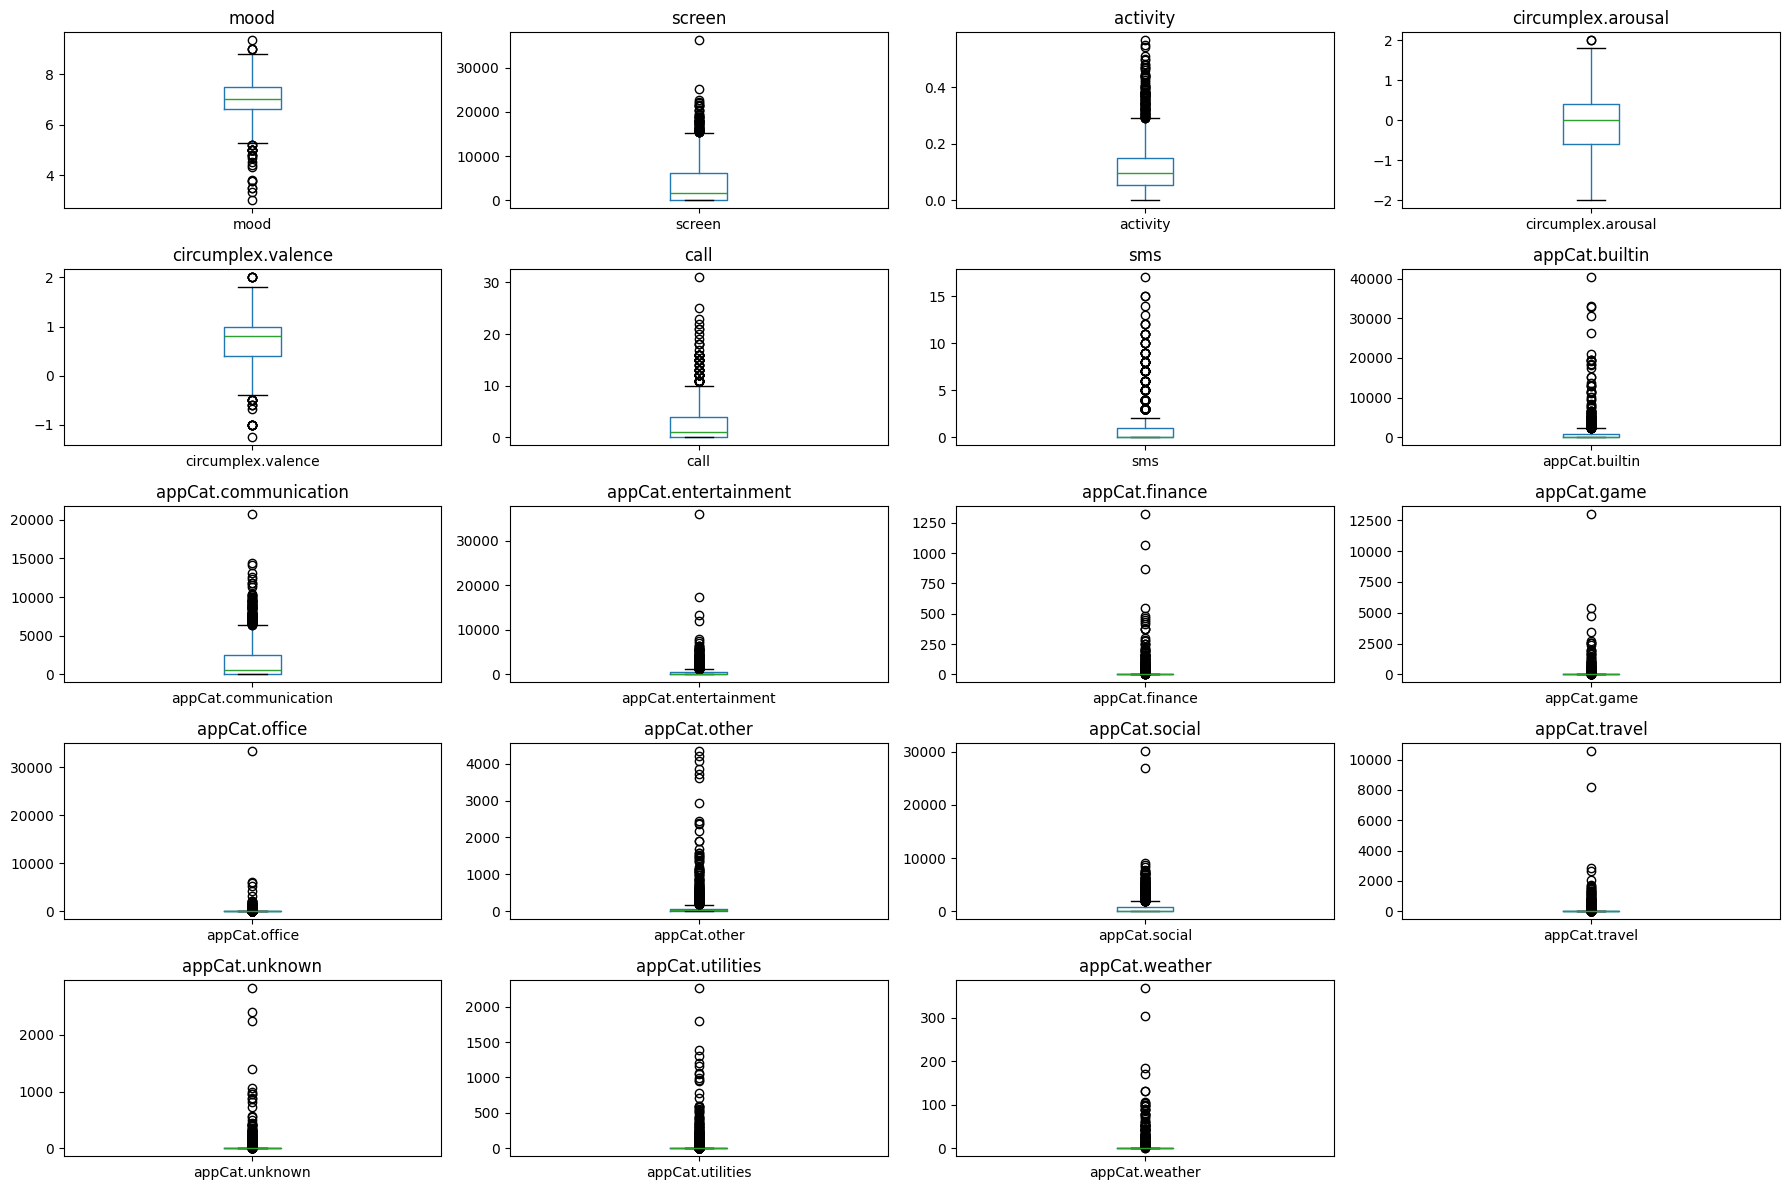

In [176]:

# Filter to exclude non-numeric columns and columns not relevant for box plot
numeric_columns = grouped_data.select_dtypes(include=['float64', 'int64']).columns

# Set up the plot
plt.figure(figsize=(18, 12))

# Plot a box plot for each variable
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(5, 4, i)  # Adjust grid size based on the number of numeric variables
    grouped_data.boxplot(column=column, grid=False)
    plt.title(column)

plt.tight_layout()
plt.savefig("Box_plot_grouped.eps", format='eps')

### Handling Outliers using capping

In [204]:
# Creating a new DataFrame to store the capped values
capped_data = grouped_data.copy()

# List of columns to exclude from capping
exclude_columns = ['mood', 'circumplex.valence', 'circumplex.arousal']

# Iterate over columns and apply capping except for excluded ones
for column in capped_data.columns:
    if column not in exclude_columns and capped_data[column].dtype in ['float64', 'int64']:
        # Calculate the 1st and 99th percentiles
        lower_bound = capped_data[column].quantile(0.01)
        upper_bound = capped_data[column].quantile(0.99)

        # Cap the values at these percentiles
        capped_data[column] = capped_data[column].clip(lower=lower_bound, upper=upper_bound)

# Now, capped_data contains the adjusted values, and the original data remains unchanged.


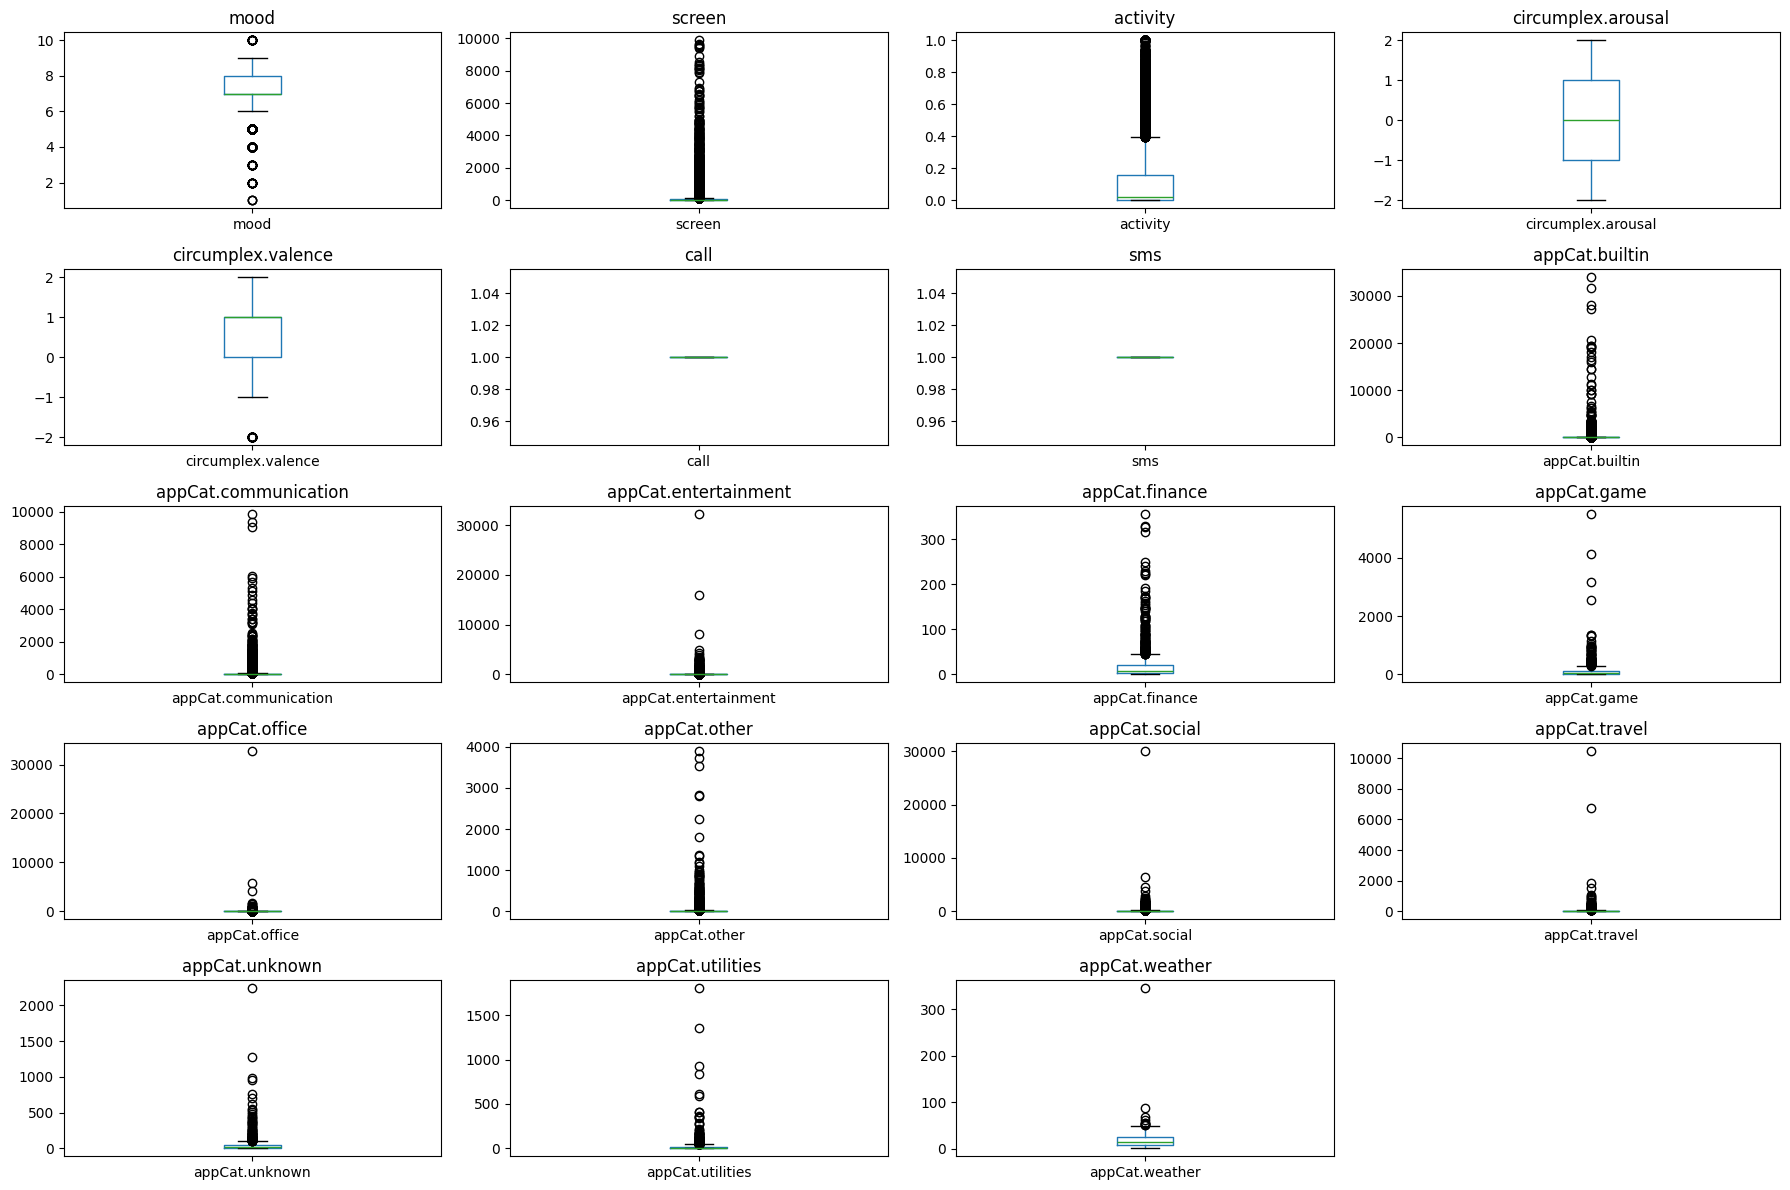

In [201]:

# Filter to exclude non-numeric columns and columns not relevant for box plot
numeric_columns = capped_data.select_dtypes(include=['float64', 'int64']).columns

# Set up the plot
plt.figure(figsize=(18, 12))

# Plot a box plot for each variable
for i, column in enumerate(numeric_columns, start=1):
    plt.subplot(5, 4, i)  # Adjust grid size based on the number of numeric variables
    data_pivoted.boxplot(column=column, grid=False)
    plt.title(column)

plt.tight_layout()
plt.savefig("Box_plot_grouped.eps", format='eps')

In [206]:
capped_data[['appCat.builtin']].max(), data_pivoted[['appCat.builtin']].max()

(variable
 appCat.builtin    11503.48664
 dtype: float64,
 variable
 appCat.builtin    33960.246
 dtype: float64)

/var/folders/h4/1kgjjbxd3q55tkg7fz83bxwr0000gn/T/ipykernel_12223/1698800710.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['date'] = pd.to_datetime(user_data['date'])


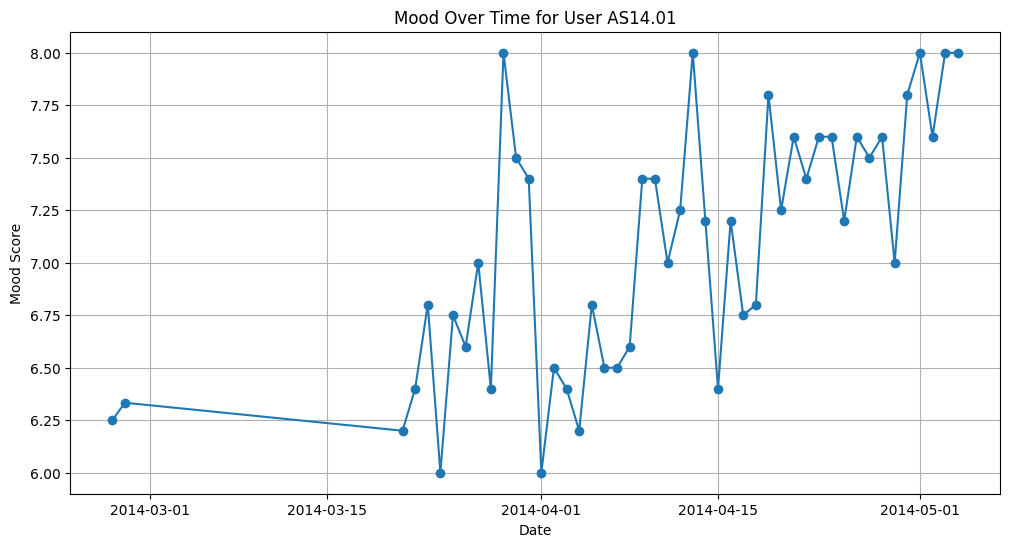

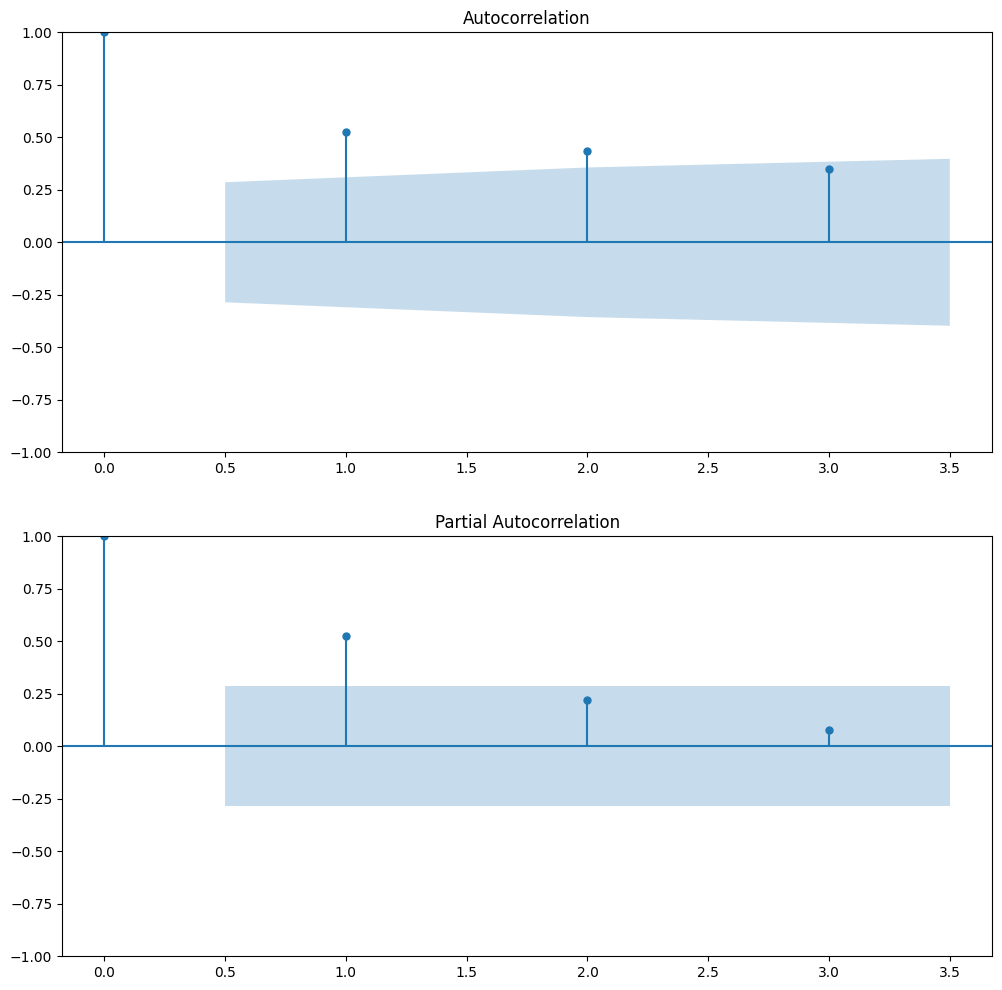

ADF Statistic: -3.5059956952860905
p-value: 0.007834440461710347


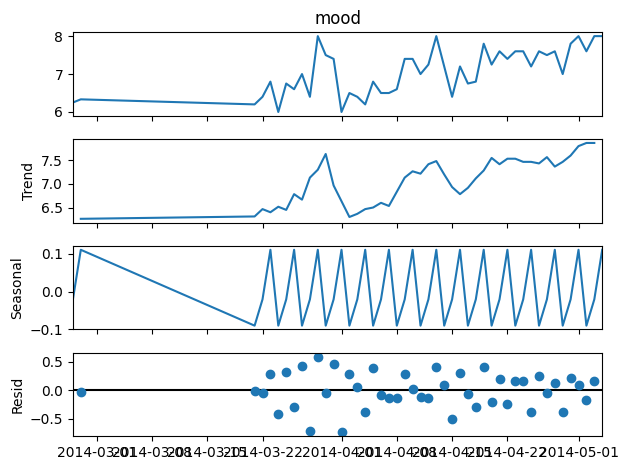

In [212]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Filter data for one user
user_data = capped_data[capped_data['id'] == 'AS14.01']

# Convert 'time' to datetime if not already and sort the data
user_data['date'] = pd.to_datetime(user_data['date'])
user_data = user_data.sort_values(by='date')

# Selecting 'mood' for analysis
mood_data = user_data[['date', 'mood']].set_index('date').dropna()

# Plot the mood time series
plt.figure(figsize=(12, 6))
plt.plot(mood_data, marker='o', linestyle='-')
plt.title('Mood Over Time for User AS14.01')
plt.xlabel('Date')
plt.ylabel('Mood Score')
plt.grid(True)
plt.show()

# ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(mood_data, lags=3, ax=ax[0])
plot_pacf(mood_data, lags=3, ax=ax[1])
plt.show()

# Augmented Dickey-Fuller test
adf_result = adfuller(mood_data['mood'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Seasonal Decomposition
result = seasonal_decompose(mood_data['mood'], model='additive', period=3)  # Assuming a monthly cycle
result.plot()
plt.show()


#### Data Imputation

In [213]:
capped_data.set_index(['id', 'date'], inplace=True)

In [214]:
def remove_consecutive_nas(group):
    # Identify rows where 'Mood' is NaN
    group['is_na'] = group['mood'].isna()

    # Flag groups of consecutive NaNs
    group['na_group'] = (group['is_na'] & (group['is_na'] != group['is_na'].shift())).cumsum()

    # Count consecutive NaNs in each group
    group['na_count'] = group.groupby('na_group')['is_na'].transform('sum')

    # Filter out groups with 2 or more consecutive NaNs
    clean_group = group[~((group['is_na'] & (group['na_count'] >= 2)))]
    return clean_group.drop(columns=['is_na', 'na_group', 'na_count'])

# Apply the function to each user group
clean_df = capped_data.groupby(level='id').apply(remove_consecutive_nas).reset_index(level=0, drop=True)


#### Checking for long gaps

In [215]:
# Calculate the time difference between consecutive entries, preserving the multi-index
grouped_data['date_diff'] = grouped_data.index.get_level_values('date').to_series().diff()

# Convert time differences to a more interpretable format, e.g., days
grouped_data['gap_days'] = grouped_data['date_diff'].dt.days

# Identify long gaps, assuming a gap of more than 3 days is considered long
grouped_data['long_gap'] = grouped_data['gap_days'] > 3

# Optionally filter to show only entries with long gaps
long_gaps = grouped_data[grouped_data['long_gap']]


KeyError: 'Requested level (date) does not match index name (None)'

#### Checking for long gaps

In [216]:

# Calculate the time difference between consecutive entries
grouped_data['date_diff'] = grouped_data.reset_index().groupby('id')['date'].diff()

# Convert time differences to days
grouped_data['gap_days'] = grouped_data['date_diff'].dt.days

# Identify long gaps, assuming a gap of more than 3 days is considered long
long_gaps = grouped_data[grouped_data['gap_days'] > 3]

# Display the instances of long gaps
print(long_gaps)

AttributeError: Can only use .dt accessor with datetimelike values

In [217]:
data_backup = clean_df.copy()

In [218]:
data_backup['appCat.professional'] = data_backup[['appCat.office', 'appCat.finance']].sum(axis=1, skipna=True)
data_backup['appCat.recreation'] = data_backup[['appCat.game','appCat.entertainment','appCat.social']].sum(axis=1, skipna=True)
data_backup['appCat.convenience'] = data_backup[['appCat.travel','appCat.utilities','appCat.weather']].sum(axis=1, skipna=True)
data_backup['appCat.plain_usage'] = data_backup[['appCat.other','appCat.unknown','appCat.builtin']].sum(axis=1, skipna=True)
column_names = ['appCat.builtin','appCat.entertainment','appCat.finance','appCat.game','appCat.office','appCat.other','appCat.social','appCat.travel','appCat.unknown','appCat.utilities','appCat.weather']
data_backup = data_backup.drop(columns=column_names, axis=1)

In [219]:
data_backup.reset_index(inplace=True)
data_backup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1290 non-null   object 
 1   date                  1290 non-null   object 
 2   mood                  1268 non-null   float64
 3   screen                1290 non-null   float64
 4   activity              1172 non-null   float64
 5   circumplex.arousal    1268 non-null   float64
 6   circumplex.valence    1266 non-null   float64
 7   call                  1290 non-null   float64
 8   sms                   1290 non-null   float64
 9   appCat.communication  1290 non-null   float64
 10  appCat.professional   1290 non-null   float64
 11  appCat.recreation     1290 non-null   float64
 12  appCat.convenience    1290 non-null   float64
 13  appCat.plain_usage    1290 non-null   float64
dtypes: float64(12), object(2)
memory usage: 141.2+ KB


In [220]:
# Convert 'date' to datetime if it's not already
data_backup['date'] = pd.to_datetime(data_backup['date'])

# Ensure data is sorted by user and date
data_backup.sort_values(by=['id', 'date'], inplace=True)

# Calculate the time difference between consecutive entries
data_backup['date_diff'] = data_backup.groupby('id')['date'].diff()

# Convert time differences to a more interpretable format, e.g., days
data_backup['gap_days'] = data_backup['date_diff'].dt.days

# Identify long gaps, assuming a gap of more than 3 days is considered long
long_gaps = data_backup[data_backup['gap_days'] > 3]

# Display the instances of long gaps
print(long_gaps[['id', 'date', 'gap_days']])

variable       id       date  gap_days
2         AS14.01 2014-03-21      22.0
394       AS14.12 2014-03-27      12.0
653       AS14.17 2014-03-21       7.0


In [221]:
gap_index = long_gaps[['id', 'date', 'gap_days']].index

#### Imputation Using Mean Values

In [222]:
numeric_columns = data_backup.select_dtypes(include=np.number).columns

# Loop over each ID
for id_val in data_backup['id'].unique():
    # Calculate median for all numeric attributes for the current ID
    median_values_by_id = data_backup.loc[data_backup['id'] == id_val, numeric_columns].mean()
    
    # Impute missing values, including zeros, with the calculated median for each attribute and each ID
    for col in numeric_columns:
        data_backup.loc[(data_backup['id'] == id_val) & (data_backup[col].isna() | (data_backup[col] == 0)), col] = median_values_by_id[col]

In [223]:
data_backup = data_backup.drop(columns=['date_diff', 'gap_days'])

In [224]:
data_backup = data_backup[2:].copy()

#### Rolling Window

##### Calculating the Mean of the Backward mean

In [243]:
users = data_backup['id'].unique()
user_dfs = {user: data_backup[data_backup['id'] == user].copy() for user in users}

for user in users:
    for column in user_dfs[user].columns:
        if column not in ['id', 'date']:
            user_dfs[user][column+"3_avg"] = user_dfs[user][column].rolling(window=3).mean()
            user_dfs[user][column+"2_avg"] = user_dfs[user][column].rolling(window=2).mean()
            user_dfs[user][column+"5_avg"] = user_dfs[user][column].rolling(window=5).mean()
            user_dfs[user][column+"4_avg"] = user_dfs[user][column].rolling(window=4).mean()

In [244]:
new_data = pd.concat(user_dfs.values(), ignore_index=True)

In [245]:
new_data.isna().sum()

variable
id                           0
date                         0
mood                         0
screen                       0
activity                     0
                          ... 
appCat.convenience4_avg     81
appCat.plain_usage3_avg     54
appCat.plain_usage2_avg     27
appCat.plain_usage5_avg    108
appCat.plain_usage4_avg     81
Length: 62, dtype: int64

In [246]:
new_data.dropna(inplace=True)

In [247]:
new_data.isna().sum()

variable
id                         0
date                       0
mood                       0
screen                     0
activity                   0
                          ..
appCat.convenience4_avg    0
appCat.plain_usage3_avg    0
appCat.plain_usage2_avg    0
appCat.plain_usage5_avg    0
appCat.plain_usage4_avg    0
Length: 62, dtype: int64

In [248]:
new_data.head()

variable,id,date,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.communication,...,appCat.recreation5_avg,appCat.recreation4_avg,appCat.convenience3_avg,appCat.convenience2_avg,appCat.convenience5_avg,appCat.convenience4_avg,appCat.plain_usage3_avg,appCat.plain_usage2_avg,appCat.plain_usage5_avg,appCat.plain_usage4_avg
4,AS14.01,2014-03-25,6.75,18459.505800,0.098374,0.5,0.5,2.104167,1.000000,9549.37676,...,2646.4742,1929.10375,293.967333,410.71500,494.848792,259.20700,1246.464333,1190.1620,1589.5868,1142.24125
5,AS14.01,2014-03-26,6.60,16423.801000,0.101308,-0.2,0.6,2.104167,0.458333,8988.75300,...,2643.7906,3171.49925,284.931667,128.12900,214.038600,228.81675,1215.106333,1355.9025,1166.7920,1251.09700
6,AS14.01,2014-03-27,7.00,17442.149999,0.159511,0.2,0.8,2.000000,1.000000,6936.51200,...,2852.1434,3316.38300,160.867000,129.85400,228.322000,270.28450,1333.221333,1276.4270,1258.4494,1233.29450
7,AS14.01,2014-03-28,6.40,4923.489000,0.095698,-0.6,0.6,5.000000,0.458333,866.83300,...,3003.3424,2704.02875,556.514480,818.08922,498.194688,473.10911,4280.466667,5788.2025,3044.3448,3572.05250
8,AS14.01,2014-03-29,8.00,8322.622000,0.068203,0.2,1.0,4.000000,1.000000,2720.69200,...,2583.2864,2732.18875,736.861467,992.12070,493.368480,560.98735,4566.209667,6205.3850,3282.0868,3740.90600


In [249]:
corr_data = new_data.drop(columns=['id', 'date'])

In [252]:
corr_data.corr()['mood'].sort_values(ascending=True)[:20]

variable
sms5_avg                  -0.148132
sms4_avg                  -0.135985
sms3_avg                  -0.123992
sms2_avg                  -0.101655
sms                       -0.083622
call5_avg                 -0.049251
call4_avg                 -0.035299
call3_avg                 -0.026271
appCat.plain_usage        -0.019928
call2_avg                 -0.012486
appCat.plain_usage2_avg   -0.000102
appCat.plain_usage3_avg    0.005225
appCat.plain_usage4_avg    0.007715
call                       0.012035
appCat.plain_usage5_avg    0.013969
appCat.convenience         0.017087
appCat.convenience5_avg    0.017708
appCat.convenience4_avg    0.027826
appCat.convenience2_avg    0.032268
appCat.recreation          0.037644
Name: mood, dtype: float64

#### Classification

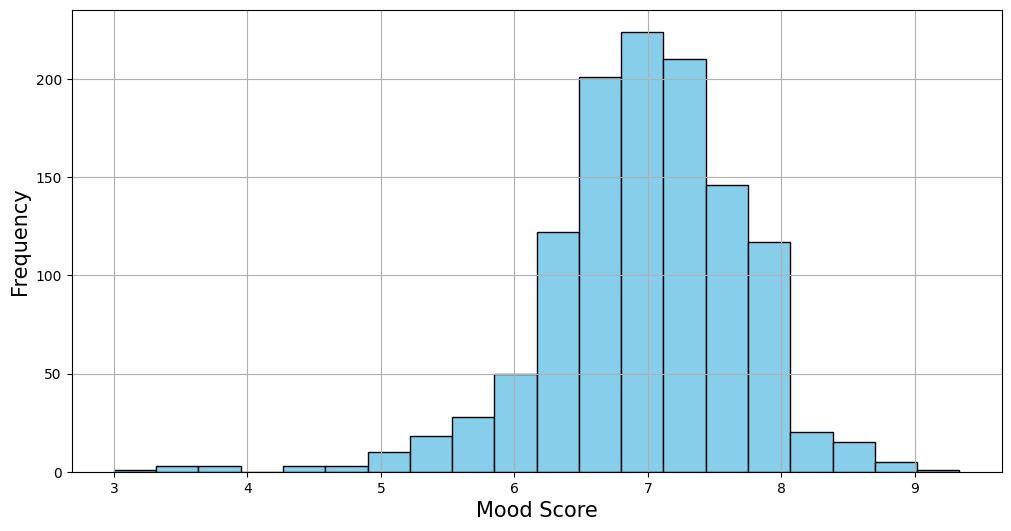

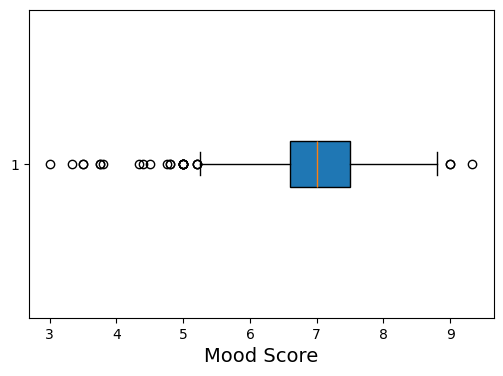

variable         mood
count     1180.000000
mean         6.990661
std          0.733470
min          3.000000
25%          6.600000
50%          7.000000
75%          7.500000
max          9.333333


In [242]:
# Calculate descriptive statistics
mood_statistics = new_data[['mood']].describe()
# Create a histogram to visualize the distribution of mood scores
plt.figure(figsize=(12, 6))
plt.hist(new_data['mood'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Mood Score', fontsize =15)
plt.ylabel('Frequency', fontsize =15)
plt.grid(True)
plt.savefig("mood_histogram.eps")
plt.show()

# Create a boxplot to visualize the distribution and identify outliers
plt.figure(figsize=(6, 4))
plt.boxplot(new_data['mood'], vert=False, patch_artist=True)
plt.xlabel('Mood Score', fontsize = 14)
plt.savefig("mood_boxplot.eps")
# Show the plots and the descriptive statistics
plt.show()

print(mood_statistics)

#### Categorising

In [253]:

# Define a function to categorize mood scores based on new percentile thresholds
def categorize_mood_percentile(score):
    if score < 6.6:
        return "Sad"
    elif score <= 7.5:
        return "Neutral"
    else:
        return "Happy"

data_classified = new_data.copy()
# Apply the new categorization function to the mood column
data_classified['mood_category'] = data_classified['mood'].apply(categorize_mood_percentile)

# Show the first few rows and the distribution of the new mood categories
data_classified.head()

variable,id,date,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.communication,...,appCat.recreation4_avg,appCat.convenience3_avg,appCat.convenience2_avg,appCat.convenience5_avg,appCat.convenience4_avg,appCat.plain_usage3_avg,appCat.plain_usage2_avg,appCat.plain_usage5_avg,appCat.plain_usage4_avg,mood_category
4,AS14.01,2014-03-25,6.75,18459.505800,0.098374,0.5,0.5,2.104167,1.000000,9549.37676,...,1929.10375,293.967333,410.71500,494.848792,259.20700,1246.464333,1190.1620,1589.5868,1142.24125,Neutral
5,AS14.01,2014-03-26,6.60,16423.801000,0.101308,-0.2,0.6,2.104167,0.458333,8988.75300,...,3171.49925,284.931667,128.12900,214.038600,228.81675,1215.106333,1355.9025,1166.7920,1251.09700,Neutral
6,AS14.01,2014-03-27,7.00,17442.149999,0.159511,0.2,0.8,2.000000,1.000000,6936.51200,...,3316.38300,160.867000,129.85400,228.322000,270.28450,1333.221333,1276.4270,1258.4494,1233.29450,Neutral
7,AS14.01,2014-03-28,6.40,4923.489000,0.095698,-0.6,0.6,5.000000,0.458333,866.83300,...,2704.02875,556.514480,818.08922,498.194688,473.10911,4280.466667,5788.2025,3044.3448,3572.05250,Sad
8,AS14.01,2014-03-29,8.00,8322.622000,0.068203,0.2,1.0,4.000000,1.000000,2720.69200,...,2732.18875,736.861467,992.12070,493.368480,560.98735,4566.209667,6205.3850,3282.0868,3740.90600,Happy


#### Train Test Split

In [254]:
def train_test_split_by_user(df, test_size=0.2, val_size=0.1):
    # Dictionary to hold train, test, and validation sets
    train_dfs = {}
    test_dfs = {}
    val_dfs = {}
    
    # Split for each user
    for user, user_df in df.groupby('id'):
        # Determine indices for splitting data
        test_index = int((1 - test_size - val_size) * len(user_df))
        val_index = test_index + int(val_size / (val_size + test_size) * len(user_df[test_index:]))

        # Assign data to train, validation, and test sets
        train_dfs[user] = user_df.iloc[:test_index]
        val_dfs[user] = user_df.iloc[test_index:val_index]
        test_dfs[user] = user_df.iloc[val_index:]

    return train_dfs, val_dfs, test_dfs


##### Data Splitting For Classification

In [255]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [256]:
# Example categorical data
categories = ['Happy', 'Neutral', 'Sad']

# Create a label encoder object
encoder = LabelEncoder()

# Fit and transform the data
encoded_labels = encoder.fit_transform(categories)

# Showing the encoded labels
print(encoded_labels)

[0 1 2]


In [257]:
data_classified['mood_Label'] = encoder.fit_transform(data_classified['mood_category'])

# Display data after label encoding
print("\nData after Label Encoding:")
print(data_classified[['mood_category', 'mood_Label']].head())


Data after Label Encoding:
variable mood_category  mood_Label
4              Neutral           1
5              Neutral           1
6              Neutral           1
7                  Sad           2
8                Happy           0


In [258]:
# Step 3: Apply One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse=False)
mood_onehot = onehot_encoder.fit_transform(data_classified[['mood_category']])


/Users/divyagajera/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [259]:
mood_onehot_df = pd.DataFrame(mood_onehot, columns=["mood_" + cls for cls in onehot_encoder.categories_[0]])

In [260]:
mood_onehot_df.shape, data_classified.shape

((1180, 3), (1180, 64))

In [261]:
data_classified = data_classified.reset_index(drop=True)

In [262]:
data_classified

variable,id,date,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.communication,...,appCat.convenience3_avg,appCat.convenience2_avg,appCat.convenience5_avg,appCat.convenience4_avg,appCat.plain_usage3_avg,appCat.plain_usage2_avg,appCat.plain_usage5_avg,appCat.plain_usage4_avg,mood_category,mood_Label
0,AS14.01,2014-03-25,6.75,18459.505800,0.098374,0.500000,0.5,2.104167,1.000000,9549.376760,...,293.967333,410.715000,494.848792,259.207000,1246.464333,1190.162000,1589.586800,1142.241250,Neutral,1
1,AS14.01,2014-03-26,6.60,16423.801000,0.101308,-0.200000,0.6,2.104167,0.458333,8988.753000,...,284.931667,128.129000,214.038600,228.816750,1215.106333,1355.902500,1166.792000,1251.097000,Neutral,1
2,AS14.01,2014-03-27,7.00,17442.149999,0.159511,0.200000,0.8,2.000000,1.000000,6936.512000,...,160.867000,129.854000,228.322000,270.284500,1333.221333,1276.427000,1258.449400,1233.294500,Neutral,1
3,AS14.01,2014-03-28,6.40,4923.489000,0.095698,-0.600000,0.6,5.000000,0.458333,866.833000,...,556.514480,818.089220,498.194688,473.109110,4280.466667,5788.202500,3044.344800,3572.052500,Sad,2
4,AS14.01,2014-03-29,8.00,8322.622000,0.068203,0.200000,1.0,4.000000,1.000000,2720.692000,...,736.861467,992.120700,493.368480,560.987350,4566.209667,6205.385000,3282.086800,3740.906000,Happy,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,AS14.33,2014-05-27,6.20,4089.879001,0.012704,-0.600000,0.4,1.000000,2.000000,2078.403000,...,90.116826,86.684239,100.948286,96.886489,1627.891333,1076.826500,1399.318200,1477.508000,Sad,2
1176,AS14.33,2014-05-28,8.20,14320.867998,0.103301,-0.406589,1.2,10.000000,1.000000,1936.415000,...,68.011492,43.419500,83.642391,75.254119,1744.881667,1975.034500,1798.204800,1991.166500,Happy,0
1177,AS14.33,2014-05-29,7.00,3569.341000,0.169354,-1.333333,1.0,5.000000,1.000000,435.105000,...,30.325667,17.402000,61.030895,52.043119,1459.768333,1755.114000,1678.780400,1415.970250,Neutral,1
1178,AS14.33,2014-05-30,6.80,9497.646999,0.192901,-0.800000,-0.4,4.000000,0.704545,1670.842000,...,440.092333,644.805500,298.729095,344.112500,2204.980000,1766.974000,1753.718600,1871.004250,Neutral,1


In [263]:
data_class = pd.concat([data_classified, mood_onehot_df], axis=1)

In [264]:
corr_data_c = data_class.drop(columns=['id', 'date', 'mood_category', 'mood_Label','mood_Happy', 'mood_Neutral', 'mood_Sad'])

In [265]:
corr_data_c.corr()['mood'].sort_values(ascending=False)[:10]

mood                       1.000000
mood2_avg                  0.859827
mood3_avg                  0.782577
mood4_avg                  0.718937
mood5_avg                  0.693052
circumplex.valence         0.668521
circumplex.valence2_avg    0.566978
circumplex.valence3_avg    0.507754
circumplex.valence4_avg    0.442874
circumplex.valence5_avg    0.423675
Name: mood, dtype: float64

In [266]:
data_class.head()

,id,date,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.communication,...,appCat.convenience4_avg,appCat.plain_usage3_avg,appCat.plain_usage2_avg,appCat.plain_usage5_avg,appCat.plain_usage4_avg,mood_category,mood_Label,mood_Happy,mood_Neutral,mood_Sad
0,AS14.01,2014-03-25,6.75,18459.505800,0.098374,0.5,0.5,2.104167,1.000000,9549.37676,...,259.20700,1246.464333,1190.1620,1589.5868,1142.24125,Neutral,1,0.0,1.0,0.0
1,AS14.01,2014-03-26,6.60,16423.801000,0.101308,-0.2,0.6,2.104167,0.458333,8988.75300,...,228.81675,1215.106333,1355.9025,1166.7920,1251.09700,Neutral,1,0.0,1.0,0.0
2,AS14.01,2014-03-27,7.00,17442.149999,0.159511,0.2,0.8,2.000000,1.000000,6936.51200,...,270.28450,1333.221333,1276.4270,1258.4494,1233.29450,Neutral,1,0.0,1.0,0.0
3,AS14.01,2014-03-28,6.40,4923.489000,0.095698,-0.6,0.6,5.000000,0.458333,866.83300,...,473.10911,4280.466667,5788.2025,3044.3448,3572.05250,Sad,2,0.0,0.0,1.0
4,AS14.01,2014-03-29,8.00,8322.622000,0.068203,0.2,1.0,4.000000,1.000000,2720.69200,...,560.98735,4566.209667,6205.3850,3282.0868,3740.90600,Happy,0,1.0,0.0,0.0


In [267]:
train_dfs_c, test_dfs_c, val_dfs_c = train_test_split_by_user(data_class, test_size=0.2, val_size=0.1)

In [268]:
# Concatenate the DataFrames for each user
train_data_C = pd.concat(train_dfs_c.values(), ignore_index=False)
test_data_C = pd.concat(test_dfs_c.values(), ignore_index=False)
val_data_C = pd.concat(val_dfs_c.values(), ignore_index=False)

In [269]:
train_data_C.shape, val_data_C.shape, test_data_C.shape

((816, 67), (250, 67), (114, 67))

In [270]:
train_data_C.columns

Index(['id', 'date', 'mood', 'screen', 'activity', 'circumplex.arousal',
       'circumplex.valence', 'call', 'sms', 'appCat.communication',
       'appCat.professional', 'appCat.recreation', 'appCat.convenience',
       'appCat.plain_usage', 'mood3_avg', 'mood2_avg', 'mood5_avg',
       'mood4_avg', 'screen3_avg', 'screen2_avg', 'screen5_avg', 'screen4_avg',
       'activity3_avg', 'activity2_avg', 'activity5_avg', 'activity4_avg',
       'circumplex.arousal3_avg', 'circumplex.arousal2_avg',
       'circumplex.arousal5_avg', 'circumplex.arousal4_avg',
       'circumplex.valence3_avg', 'circumplex.valence2_avg',
       'circumplex.valence5_avg', 'circumplex.valence4_avg', 'call3_avg',
       'call2_avg', 'call5_avg', 'call4_avg', 'sms3_avg', 'sms2_avg',
       'sms5_avg', 'sms4_avg', 'appCat.communication3_avg',
       'appCat.communication2_avg', 'appCat.communication5_avg',
       'appCat.communication4_avg', 'appCat.professional3_avg',
       'appCat.professional2_avg', 'appCat.prof

In [271]:
train_data_C = train_data_C[['mood_Neutral','mood_Happy','mood_Sad', 'mood2_avg', 'mood3_avg', 'circumplex.valence2_avg', 'circumplex.valence3_avg']]
val_data_C = val_data_C[['mood_Neutral','mood_Happy','mood_Sad', 'mood2_avg', 'mood3_avg', 'circumplex.valence2_avg', 'circumplex.valence3_avg']]
test_data_C = test_data_C[['mood_Neutral','mood_Happy','mood_Sad', 'mood2_avg', 'mood3_avg','circumplex.valence2_avg', 'circumplex.valence3_avg']]

#### With all the features

In [272]:
train_data_C.head()

,mood_Neutral,mood_Happy,mood_Sad,mood2_avg,mood3_avg,circumplex.valence2_avg,circumplex.valence3_avg
0,1.0,0.0,0.0,6.375,6.516667,0.60195,0.667967
1,1.0,0.0,0.0,6.675,6.450000,0.55000,0.601300
2,1.0,0.0,0.0,6.800,6.783333,0.70000,0.633333
3,0.0,0.0,1.0,6.700,6.666667,0.70000,0.666667
4,0.0,1.0,0.0,7.200,7.133333,0.80000,0.800000


In [273]:
train_data_C[['mood_Neutral','mood_Happy','mood_Sad']]

,mood_Neutral,mood_Happy,mood_Sad
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
...,...,...,...
1163,0.0,0.0,1.0
1164,1.0,0.0,0.0
1165,0.0,0.0,1.0
1166,0.0,0.0,1.0


In [274]:
y_train_C = train_data_C[['mood_Neutral','mood_Happy','mood_Sad']]
x_train_C = train_data_C.drop(columns=['mood_Neutral','mood_Happy','mood_Sad'])
y_test_C = test_data_C[['mood_Neutral','mood_Happy','mood_Sad',]]
x_test_C = test_data_C.drop(columns=['mood_Neutral','mood_Happy','mood_Sad',])
y_val_C = val_data_C[['mood_Neutral','mood_Happy','mood_Sad',]]
x_val_C = val_data_C.drop(columns=['mood_Neutral','mood_Happy','mood_Sad',])

In [275]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, roc_auc_score

#### Prunning

In [276]:

# Create a Random Forest Classifier with pruning
rf_classifier = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    max_depth=10,          # Maximum depth of the tree
    min_samples_split=10,  # Minimum number of samples required to split an internal node
    min_samples_leaf=4,    # Minimum number of samples required to be at a leaf node
    max_leaf_nodes=50,     # Maximum number of leaf nodes
    random_state=42,        # Seed for reproducibility
    oob_score=True
)

# Fit the model
rf_classifier.fit(x_train_C, y_train_C)

# Predict
predictions = rf_classifier.predict(x_test_C)


In [277]:
#rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=12, oob_score=True, bootstrap=True)
#rf_classifier.fit(x_train_C, y_train_C)

# Prediction and Evaluation
train_accuracy = accuracy_score(y_train_C, rf_classifier.predict(x_train_C))
test_accuracy = accuracy_score(y_test_C, rf_classifier.predict(x_test_C))
val_accuracy = accuracy_score(y_val_C, rf_classifier.predict(x_val_C))
oob_error = 1 - rf_classifier.oob_score_

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Validation Accuracy:", val_accuracy)
print("OOB Error:", oob_error)

# Cross-validation
cv_scores = cross_val_score(rf_classifier, x_train_C, y_train_C, cv=5)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Training Accuracy: 0.8357843137254902
Test Accuracy: 0.7982456140350878
Validation Accuracy: 0.78
OOB Error: 0.25
CV Accuracy: 0.75 (+/- 0.11)


### AUC andn F1 Score

In [278]:
 # Convert predictions from one-hot back to class labels if necessary
y_test_labels = np.argmax(y_test_C, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

# F1 Score - Calculated for each class and then averaged (you could also weigh them by support)
f1_micro = f1_score(y_test_C, predictions, average='micro')
f1_macro = f1_score(y_test_labels, y_pred_labels, average='macro')
f1_weighted = f1_score(y_test_C, predictions, average='weighted')

# Print the F1 scores
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Weighted):", f1_weighted)

F1 Score (Micro): 0.8017621145374448
F1 Score (Macro): 0.7907397876517793
F1 Score (Weighted): 0.8008403242427504


In [279]:
# Predict probabilities and classes
y_pred_prob = rf_classifier.predict_proba(x_test_C)
print('shape of y_pred_prob',np.array(y_pred_prob).shape)

y_pred_prob_combined = np.array([probs[:, 1] for probs in y_pred_prob]).T

# Now y_pred_prob_combined should have the shape (114, 3)
print("Shape of combined prediction probabilities:", y_pred_prob_combined.shape)

# Calculate ROC AUC
# Note: y_test needs to be in a one-hot encoded format
roc_auc = roc_auc_score(y_test_C, np.array(y_pred_prob_combined), multi_class='ovr')
print(roc_auc)

shape of y_pred_prob (3, 114, 2)
Shape of combined prediction probabilities: (114, 3)
0.9130267872946939


### Without Prunning

In [280]:
# Train a simple model (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
model.fit(x_train_C, y_train_C)

RandomForestClassifier(oob_score=True, random_state=42)

In [282]:
 # Convert predictions from one-hot back to class labels if necessary
y_test_labels = np.argmax(y_test_C, axis=1)
y_pred_labels_ = np.argmax(model.predict(x_test_C), axis=1)

# F1 Score - Calculated for each class and then averaged (you could also weigh them by support)
f1_micro = f1_score(y_test_C, model.predict(x_test_C), average='micro')
f1_macro = f1_score(y_test_labels, y_pred_labels_, average='macro')
f1_weighted = f1_score(y_test_C, model.predict(x_test_C), average='weighted')

# Print the F1 scores
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)
print("F1 Score (Weighted):", f1_weighted)

F1 Score (Micro): 0.7929515418502202
F1 Score (Macro): 0.7745938921377519
F1 Score (Weighted): 0.7915642624060368


In [283]:
# Predict probabilities and classes
y_pred_prob_= model.predict_proba(x_test_C)
print('shape of y_pred_prob',np.array(y_pred_prob).shape)

y_pred_prob_combined_ = np.array([probs[:, 1] for probs in y_pred_prob_]).T

# Now y_pred_prob_combined should have the shape (114, 3)
print("Shape of combined prediction probabilities:", y_pred_prob_combined_.shape)

# Calculate ROC AUC
# Note: y_test needs to be in a one-hot encoded format
roc_auc = roc_auc_score(y_test_C, np.array(y_pred_prob_combined), multi_class='ovr')
print('ROC', roc_auc)

shape of y_pred_prob (3, 114, 2)
Shape of combined prediction probabilities: (114, 3)
ROC 0.9130267872946939


### SVM  Classification Algorithm

In [284]:
train_dfs_c, test_dfs_c, val_dfs_c = train_test_split_by_user(data_class, test_size=0.2, val_size=0.1)
# Concatenate the DataFrames for each user
train_data_SVM = pd.concat(train_dfs_c.values())
test_data_SVM = pd.concat(test_dfs_c.values())
val_data_SVM = pd.concat(val_dfs_c.values())

In [285]:
train_data_SVM.head()

,id,date,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.communication,...,appCat.convenience4_avg,appCat.plain_usage3_avg,appCat.plain_usage2_avg,appCat.plain_usage5_avg,appCat.plain_usage4_avg,mood_category,mood_Label,mood_Happy,mood_Neutral,mood_Sad
0,AS14.01,2014-03-25,6.75,18459.505800,0.098374,0.5,0.5,2.104167,1.000000,9549.37676,...,259.20700,1246.464333,1190.1620,1589.5868,1142.24125,Neutral,1,0.0,1.0,0.0
1,AS14.01,2014-03-26,6.60,16423.801000,0.101308,-0.2,0.6,2.104167,0.458333,8988.75300,...,228.81675,1215.106333,1355.9025,1166.7920,1251.09700,Neutral,1,0.0,1.0,0.0
2,AS14.01,2014-03-27,7.00,17442.149999,0.159511,0.2,0.8,2.000000,1.000000,6936.51200,...,270.28450,1333.221333,1276.4270,1258.4494,1233.29450,Neutral,1,0.0,1.0,0.0
3,AS14.01,2014-03-28,6.40,4923.489000,0.095698,-0.6,0.6,5.000000,0.458333,866.83300,...,473.10911,4280.466667,5788.2025,3044.3448,3572.05250,Sad,2,0.0,0.0,1.0
4,AS14.01,2014-03-29,8.00,8322.622000,0.068203,0.2,1.0,4.000000,1.000000,2720.69200,...,560.98735,4566.209667,6205.3850,3282.0868,3740.90600,Happy,0,1.0,0.0,0.0


In [286]:
train_data_SVM = train_data_SVM[['mood2_avg', 'mood3_avg', 'circumplex.valence2_avg', 'circumplex.valence3_avg', 'mood_Label']]
val_data_SVM = val_data_SVM[['mood2_avg', 'mood3_avg', 'circumplex.valence2_avg', 'circumplex.valence3_avg', 'mood_Label' ]]
test_data_SVM = test_data_SVM[['mood2_avg', 'mood3_avg','circumplex.valence2_avg', 'circumplex.valence3_avg', 'mood_Label']]

In [287]:
y_train_SVM = train_data_SVM[['mood_Label']].values
x_train_SVM = train_data_SVM.drop(columns=['mood_Label'])
y_test_SVM = test_data_SVM[['mood_Label']].values
x_test_SVM = test_data_SVM.drop(columns=['mood_Label'])
y_val_SVM = val_data_SVM[['mood_Label']].values
x_val_SVM = val_data_SVM.drop(columns=['mood_Label'])

In [288]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [289]:
# Train SVM Classifier
svm_model = SVC(kernel='linear')
svm_model.fit(x_train_SVM, y_train_SVM.ravel())


SVC(kernel='linear')

In [290]:
# Predict
y_pred_SVM = svm_model.predict(x_test_SVM)
# Evaluate the model
print("Accuracy:", accuracy_score(y_test_SVM, y_pred_SVM))

Accuracy: 0.7982456140350878


In [291]:
# Flatten the y arrays to 1D
y_train_SVM = y_train_SVM.ravel()
y_test_SVM = y_test_SVM.ravel()
y_val_SVM = y_val_SVM.ravel()

# Train the SVM Classifier
svm_model = SVC(kernel='linear', probability=True)  # probability=True to allow using predict_proba
svm_model.fit(x_train_SVM, y_train_SVM)

# Predictions
y_train_pred = svm_model.predict(x_train_SVM)
y_test_pred = svm_model.predict(x_test_SVM)
y_val_pred = svm_model.predict(x_val_SVM)

# Probabilities for AUC-ROC
y_train_proba = svm_model.predict_proba(x_train_SVM)
y_test_proba = svm_model.predict_proba(x_test_SVM)
y_val_proba = svm_model.predict_proba(x_val_SVM)

# Metrics for training set
train_accuracy = accuracy_score(y_train_SVM, y_train_pred)
train_f1 = f1_score(y_train_SVM, y_train_pred, average='weighted')  # Adjusted for multiclass
train_auc = roc_auc_score(y_train_SVM, y_train_proba, multi_class='ovr', average='weighted')  # OvR strategy

# Metrics for testing set
test_accuracy = accuracy_score(y_test_SVM, y_test_pred)
test_f1 = f1_score(y_test_SVM, y_test_pred, average='weighted')  # Adjusted for multiclass
test_auc = roc_auc_score(y_test_SVM, y_test_proba, multi_class='ovr', average='weighted')  # OvR strategy

# Metrics for validation set
val_accuracy = accuracy_score(y_val_SVM, y_val_pred)
val_f1 = f1_score(y_val_SVM, y_val_pred, average='weighted')  # Adjusted for multiclass
val_auc = roc_auc_score(y_val_SVM, y_val_proba, multi_class='ovr', average='weighted')  # OvR strategy

# Printing results
print(f"Training: Accuracy={train_accuracy}, F1 Score={train_f1}, AUC-ROC={train_auc}")
print(f"Testing: Accuracy={test_accuracy}, F1 Score={test_f1}, AUC-ROC={test_auc}")
print(f"Validation: Accuracy={val_accuracy}, F1 Score={val_f1}, AUC-ROC={val_auc}")


Training: Accuracy=0.7622549019607843, F1 Score=0.7600369938838633, AUC-ROC=0.8749262580657645
Testing: Accuracy=0.7982456140350878, F1 Score=0.7965289851254764, AUC-ROC=0.8970698990584229
Validation: Accuracy=0.784, F1 Score=0.7827725579683474, AUC-ROC=0.9052238923398405


#### RNN Classification

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout, BatchNormalization, GRU
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
warnings.filterwarnings("ignore")

In [293]:
data_LSTM = data_backup.copy()

In [294]:
data_LSTM.head()

variable,id,date,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.communication,appCat.professional,appCat.recreation,appCat.convenience,appCat.plain_usage
2,AS14.01,2014-03-21,6.20,17978.907000,0.134050,0.2,0.200000,6.000000,0.458333,6280.89000,221.750,5515.956,1437.41596,3378.969
3,AS14.01,2014-03-22,6.40,6142.161000,0.236880,0.6,0.500000,3.000000,1.000000,4962.91800,21.076,532.956,154.92600,829.572
4,AS14.01,2014-03-23,6.80,6773.832001,0.142741,0.2,0.800000,2.104167,0.458333,5237.31900,43.403,995.185,60.47200,1359.069
5,AS14.01,2014-03-24,6.00,15047.351001,0.078961,0.8,0.703901,10.000000,0.458333,9270.62900,37.116,4200.597,598.53700,933.514
6,AS14.01,2014-03-25,6.75,18459.505800,0.098374,0.5,0.500000,2.104167,1.000000,9549.37676,43.054,1987.677,222.89300,1446.810


### Standardise Columns

In [295]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()
# Select the columns to be normalized
data_LSTM['feature_mood'] = data_LSTM['mood']
cols_to_normalize = data_LSTM.columns.difference(['id', 'date', 'mood'])

# Apply the scaler to the selected columns
data_LSTM[cols_to_normalize] = scaler.fit_transform(data_LSTM[cols_to_normalize])

In [296]:
data_LSTM.head()

variable,id,date,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.communication,appCat.professional,appCat.recreation,appCat.convenience,appCat.plain_usage,feature_mood
2,AS14.01,2014-03-21,6.20,0.973964,0.297996,0.550,0.446154,0.369278,0.024429,0.657688,0.155718,0.526972,0.884082,0.268118,0.505263
3,AS14.01,2014-03-22,6.40,0.332720,0.527779,0.650,0.538462,0.180061,0.086294,0.519656,0.014800,0.050854,0.094737,0.065706,0.536842
4,AS14.01,2014-03-23,6.80,0.366940,0.317416,0.550,0.630769,0.123559,0.024429,0.548394,0.030479,0.095019,0.036602,0.107746,0.600000
5,AS14.01,2014-03-24,6.00,0.815150,0.174894,0.700,0.601200,0.621567,0.024429,0.970807,0.026064,0.401291,0.367770,0.073958,0.473684
6,AS14.01,2014-03-25,6.75,1.000000,0.218274,0.625,0.538462,0.123559,0.086294,1.000000,0.030234,0.189850,0.136569,0.114712,0.592105


In [297]:
# sort the dataframe by id and date
data_LSTM.sort_values(['id', 'date'])

# Define the number of steps in each input sequence
n_steps = 5

# Prepare columns to be used as features
feature_columns = ['feature_mood', 'screen', 'activity', 'circumplex.arousal',
                   'circumplex.valence', 'call', 'sms', 'appCat.communication',
                   'appCat.professional', 'appCat.recreation', 'appCat.convenience',
                   'appCat.plain_usage']

user_ids = data_LSTM['id'].unique()

df_test = data_LSTM[(data_LSTM['id'] == 'AS14.05') | (data_LSTM['id'] == 'AS14.23')].copy()

df = data_LSTM[~data_LSTM['id'].isin(['AS14.05', 'AS14.23'])]

# Initialize lists to hold the input and output data
X_train, y_train = [], []
X_val, y_val = [], []
# Iterate over each unique ID
for uid in df['id'].unique():
    X, y = [], []
    user_df = df[df['id'] == uid]  # Extract data for the current ID
    
    # Check if there are enough rows to form at least one sequence
    if len(user_df) > n_steps:
        for i in range(len(user_df) - n_steps):
            # Extract the rows for the input sequence
            X.append(user_df[feature_columns].iloc[i:i + n_steps].values)

            # Get the mood of the day following the last day in the input sequence
            y.append(user_df['mood'].iloc[i + n_steps])
            
    split_index = int((1 - 0.1) * len(X))
    #print(X)
    X_train.extend(X[:split_index])
    X_val.extend(X[split_index:])
    y_train.extend(y[:split_index])
    y_val.extend(y[split_index:])

In [298]:
X_train[0].shape

(5, 12)

In [299]:
y_train_data = pd.DataFrame(y_train, columns =['mood'])
y_val_data = pd.DataFrame(y_val, columns =['mood'])

In [300]:
# Apply the new categorization function to the mood column
y_train_data['mood_category'] = y_train_data['mood'].apply(categorize_mood_percentile)
y_val_data['mood_category'] = y_val_data['mood'].apply(categorize_mood_percentile)

# Show the first few rows and the distribution of the new mood categories
y_train_data.head()

,mood,mood_category
0,6.6,Neutral
1,7.0,Neutral
2,6.4,Sad
3,8.0,Happy
4,7.5,Neutral


In [301]:
y_train_data['mood_Label'] = encoder.fit_transform(y_train_data['mood_category'])
y_val_data['mood_Label'] = encoder.fit_transform(y_val_data['mood_category'])

In [302]:
y_val_data.head()

,mood,mood_category,mood_Label
0,8.000000,Happy,0
1,7.600000,Happy,0
2,8.000000,Happy,0
3,8.000000,Happy,0
4,7.065603,Neutral,1


In [303]:
onehot_encoder = OneHotEncoder(sparse=False)
y_lstm_train = onehot_encoder.fit_transform(y_train_data[['mood_category']])
y_lstm_val = onehot_encoder.fit_transform(y_val_data[['mood_category']])

In [304]:
y_lstm_val

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

In [352]:
model = Sequential([
    SimpleRNN(32, activation='tanh', input_shape=(n_steps, len(feature_columns)), return_sequences=True),
    Dropout(0.1),  # Added dropout for regularization
    SimpleRNN(16, activation='relu'),
    Dropout(0.1),  # Added dropout for regularization
    #SimpleRNN(32, activation='tanh', return_sequences=True),
    #Dropout(0.25),  # Added dropout for regularization
    #SimpleRNN(5, activation='relu'),
    #Dropout(0.25),  # Added dropout for regularization
    Dense(units=3, activation='softmax')
])



In [324]:
from keras.regularizers import l1_l2

model = Sequential([
    SimpleRNN(32, activation='tanh', input_shape=(n_steps, len(feature_columns)), 
              return_sequences=True),
    SimpleRNN(16, activation='relu'),
    Dense(units=3, activation='softmax')
])


In [353]:
model = Sequential([
    SimpleRNN(16, activation='tanh', input_shape=(n_steps, len(feature_columns))),
    Dense(units=3, activation='softmax')
])

In [308]:
X_train = np.array(X_train)
X_val = np.array(X_val)

In [309]:
y_lstm_train.shape, X_train.shape

((950, 3), (950, 5, 12))

In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

Epoch 1/150


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.5651 - accuracy: 0.3904 - f1_score: 0.3050 - loss: 1.1016 - val_AUC: 0.6660 - val_accuracy: 0.5833 - val_f1_score: 0.2793 - val_loss: 1.0062
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.6570 - accuracy: 0.5446 - f1_score: 0.2612 - loss: 1.0304 - val_AUC: 0.6918 - val_accuracy: 0.5833 - val_f1_score: 0.2963 - val_loss: 0.9854
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.6835 - accuracy: 0.5393 - f1_score: 0.2788 - loss: 1.0049 - val_AUC: 0.7131 - val_accuracy: 0.6000 - val_f1_score: 0.3198 - val_loss: 0.9612
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.6854 - accuracy: 0.5297 - f1_score: 0.3032 - loss: 1.0000 - val_AUC: 0.7320 - val_accuracy: 0.6000 - val_f1_score: 0.3201 - val_loss: 0.9391
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.6964 - accuracy: 0.5438 - f1_score: 0.2938 - loss: 0.9906 - val_AUC: 0.7462 - val_accuracy: 0.6000 - val_f1_score: 0.3597 - val_loss: 0.9259
Epoch 6

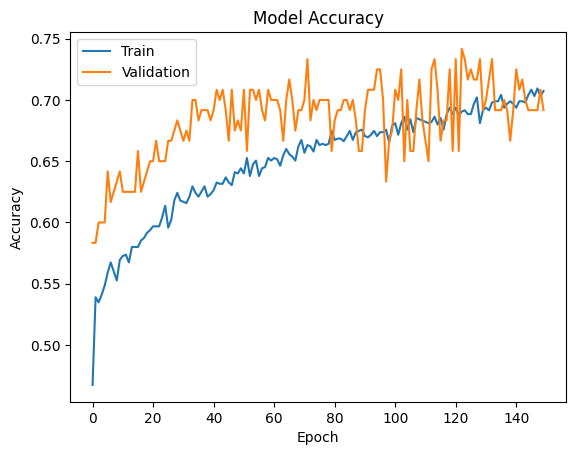

In [354]:
# Compile the model using categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'f1_score'])
history = model.fit(X_train, y_lstm_train, epochs=150, validation_data=(X_val, y_lstm_val))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [355]:
# Make predictions on the test set
def plot_user_predictions(user_id, df_test, feature_columns, n_steps):
    
    user_df = df_test[df_test['id'] == user_id]
    user_X, user_actual = [], []
    
    #X, y = [], []
    # Iterate over each unique ID
    for uid in df_test['id'].unique():
        
        user_df = df_test[df_test['id'] == uid]  # Extract data for the current ID
        # Check if there are enough rows to form at least one sequence
        if len(user_df) > n_steps:
            for i in range(len(user_df) - n_steps):
                # Extract the rows for the input sequence
                user_X.append(user_df[feature_columns].iloc[i:i + n_steps].values)

                # Get the mood of the day following the last day in the input sequence
                user_actual.append(user_df['mood'].iloc[i + n_steps])
    
    return np.array(user_X), np.array(user_actual)
    

In [356]:
X_lstm_test, y_lstm_test = plot_user_predictions(user_id, df_test, feature_columns, n_steps)

In [357]:
y_lstm_test_data = pd.DataFrame(y_lstm_test, columns =['mood'])
# Apply the new categorization function to the mood column
y_lstm_test_data['mood_category'] = y_lstm_test_data['mood'].apply(categorize_mood_percentile)

# Show the first few rows and the distribution of the new mood categories
y_lstm_test_data.head()

,mood,mood_category
0,6.75,Neutral
1,7.20,Neutral
2,7.25,Neutral
3,3.75,Sad
4,4.40,Sad


In [358]:
y_lstm_test_data['mood_Label'] = encoder.fit_transform(y_lstm_test_data['mood_category'])

In [359]:
onehot_encoder = OneHotEncoder(sparse=False)
y_lstm_test= onehot_encoder.fit_transform(y_lstm_test_data[['mood_category']])

In [360]:
y_lstm_test.shape

(83, 3)

In [361]:
from sklearn.metrics import confusion_matrix, classification_report

In [362]:

# Predict classes
y_pred = model.predict(X_lstm_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Actual classes
y_true = np.argmax(y_lstm_test, axis=1)  # Convert from one-hot to integers if necessary

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[ 7  1  0]
 [19 41  1]
 [ 2  6  6]]


In [363]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.88      0.39         8
           1       0.85      0.67      0.75        61
           2       0.86      0.43      0.57        14

    accuracy                           0.65        83
   macro avg       0.65      0.66      0.57        83
weighted avg       0.80      0.65      0.69        83



In [364]:
# Predict classes
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)

# Actual classes
y_true = np.argmax(y_lstm_train, axis=1)  # Convert from one-hot to integers if necessary

print(classification_report(y_true, y_pred_classes))

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
              precision    recall  f1-score   support

           0       0.75      0.58      0.66       211
           1       0.68      0.86      0.76       504
           2       0.74      0.48      0.58       235

    accuracy                           0.70       950
   macro avg       0.73      0.64      0.67       950
weighted avg       0.71      0.70      0.69       950



In [365]:
# Predict classes
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Actual classes
y_true = np.argmax(y_lstm_val, axis=1)  # Convert from one-hot to integers if necessary

print(classification_report(y_true, y_pred_classes))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step
              precision    recall  f1-score   support

           0       0.81      0.39      0.53        33
           1       0.71      0.87      0.78        69
           2       0.50      0.56      0.53        18

    accuracy                           0.69       120
   macro avg       0.68      0.61      0.61       120
weighted avg       0.71      0.69      0.68       120



In [366]:
# Predict probabilities on the test set
y_pred_proba = model.predict(X_lstm_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [367]:
auc_roc = roc_auc_score(y_lstm_test, y_pred_proba, multi_class='ovr')
print("AUC-ROC:", auc_roc)

AUC-ROC: 0.7923702044372037


In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC for each class
fpr, tpr, thresholds = roc_curve(y_lstm_test, y_pred[:, 1])  # assuming class 1 is the positive class
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Correlation Matrix 

In [ ]:
corr_data = new_data.drop(columns=['id', 'date'])
fig_corr= plt.figure(figsize=(12, 8))
cmap = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(corr_data.corr(), annot=True, cmap=cmap)

fig_corr.savefig('correlation_.pdf')

In [ ]:
corr_data.corr()['mood'].sort_values(ascending=False)[:10]

In [ ]:
new_data = new_data[['id','date','mood2_avg', 'mood3_avg', 'circumplex.valence', 'circumplex.valence2_avg','circumplex.valence3_avg', 'mood']]

In [ ]:
corr_data = new_data.drop(columns=[ 'id'])

In [ ]:
corr_data.corr()['mood'].sort_values(ascending=False)

In [ ]:
# Standardize input features (not target)
from sklearn.preprocessing import MinMaxScaler

In [ ]:
new_data = new_data.set_index(['id', 'date'])

#### Data Splitting in the Train, Test and Validation

In [368]:
def train_test_split_by_user(df, test_size=0.2, val_size=0.1):
    # Dictionary to hold train, test, and validation sets
    train_dfs = {}
    test_dfs = {}
    val_dfs = {}
    
    # Split for each user
    for user, user_df in df.groupby('id'):
        # Determine indices for splitting data
        test_index = int((1 - test_size - val_size) * len(user_df))
        val_index = test_index + int(val_size / (val_size + test_size) * len(user_df[test_index:]))

        # Assign data to train, validation, and test sets
        train_dfs[user] = user_df.iloc[:test_index]
        val_dfs[user] = user_df.iloc[test_index:val_index]
        test_dfs[user] = user_df.iloc[val_index:]

    return train_dfs, val_dfs, test_dfs

train_dfs, test_dfs, val_dfs = train_test_split_by_user(new_data)

In [369]:
# Concatenate the DataFrames for each user
train_data = pd.concat(train_dfs.values(), ignore_index=False)
test_data = pd.concat(test_dfs.values(), ignore_index=False)
val_data = pd.concat(val_dfs.values(), ignore_index=False)

In [370]:
train_data.shape, val_data.shape, test_data.shape

((816, 62), (250, 62), (114, 62))

In [371]:
train_data.reset_index(inplace = True)
test_data.reset_index(inplace = True)
val_data.reset_index(inplace= True)

In [372]:
test_data.drop(columns=['date', 'id'], inplace=True)
train_data = train_data.drop(columns=['date', 'id'])
val_data = val_data.drop(columns=['date', 'id'])
test_data.head()

variable,index,mood,screen,activity,circumplex.arousal,circumplex.valence,call,sms,appCat.communication,appCat.professional,...,appCat.recreation5_avg,appCat.recreation4_avg,appCat.convenience3_avg,appCat.convenience2_avg,appCat.convenience5_avg,appCat.convenience4_avg,appCat.plain_usage3_avg,appCat.plain_usage2_avg,appCat.plain_usage5_avg,appCat.plain_usage4_avg
0,33,7.6,14535.339999,0.045986,0.20,1.0,1.0,0.458333,8928.47200,18.05100,...,1552.3412,1716.66900,316.439667,335.07950,301.008000,267.58850,2316.545000,1724.6770,1771.7190,1970.23075
1,34,7.6,18459.505800,0.050903,-0.40,1.0,1.0,0.458333,9549.37676,207.83028,...,2804.0374,2763.73825,414.437987,410.04948,328.701792,380.61849,1649.186000,1335.7220,1875.8254,2111.95975
2,35,7.2,13973.942000,0.109061,-0.20,0.8,2.0,1.000000,7279.14400,21.07100,...,2786.6958,3357.40675,410.462987,492.22248,386.752792,413.65099,1185.968000,1192.3320,1866.8598,1458.50450
3,36,7.6,15482.018999,0.214249,-0.20,1.0,3.0,4.000000,2567.85700,27.26700,...,3184.7120,3349.99875,590.326987,598.91300,488.227992,504.48124,1099.512000,900.1660,1349.5780,1117.94400
4,75,8.0,2773.043001,0.187074,0.75,1.0,8.0,7.000000,1822.47700,0.00000,...,617.3744,456.18525,204.435000,122.06700,354.278400,311.05850,1086.287667,710.5895,1277.5698,1235.79575


In [373]:
train_data = train_data[['mood', 'mood2_avg', 'mood3_avg', 'circumplex.valence', 'circumplex.valence2_avg', 'circumplex.valence3_avg', 'mood5_avg', 'mood4_avg']]
val_data = val_data[['mood', 'mood2_avg', 'mood3_avg', 'circumplex.valence', 'circumplex.valence2_avg', 'circumplex.valence3_avg', 'mood5_avg', 'mood4_avg']]
test_data = test_data[['mood', 'mood2_avg', 'mood3_avg', 'circumplex.valence', 'circumplex.valence2_avg', 'circumplex.valence3_avg', 'mood5_avg', 'mood4_avg']]

In [374]:
x_train = train_data.drop(columns=['mood'])
y_train = train_data['mood']
x_test = test_data.drop(columns=['mood'])
y_test = test_data[['mood']]
x_val = val_data.drop(columns=['mood'])
y_val = val_data[['mood']]

In [375]:
x_test = test_data.drop(columns=['mood'])
y_test = test_data[['mood']]
x_val = val_data.drop(columns=['mood'])
y_val = val_data[['mood']]

In [376]:
rf = RandomForestRegressor(n_estimators = 100, max_depth=1,min_samples_leaf=1,min_samples_split=2, bootstrap=True, random_state = 12)
rf.fit(x_train, y_train)
y_train_pred=rf.predict(x_train)
y_val_pred=rf.predict(x_val)
y_test_pred=rf.predict(x_test)
print('MAE train:', metrics.mean_absolute_error(y_train,y_train_pred))
print('MAE val:', metrics.mean_absolute_error(y_val,y_val_pred))
print('MAE test:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE train:', metrics.mean_squared_error(y_train,y_train_pred))
print('MSE val:', metrics.mean_squared_error(y_val,y_val_pred))
print('MSE test:', metrics.mean_squared_error(y_test,y_test_pred))
print('R2 Score: val', metrics.r2_score(y_val, y_val_pred))
print('R2 Score: test', metrics.r2_score(y_test, y_test_pred))
print('R2 Score: train', metrics.r2_score(y_train, y_train_pred))


MAE train: 0.38871936043578836
MAE val: 0.41089370588779345
MAE test: 0.3846334797048767
MSE train: 0.28603925485174997
MSE val: 0.2734425335970345
MSE test: 0.28128351633397963
R2 Score: val 0.49502395777781516
R2 Score: test 0.45835516849760716
R2 Score: train 0.4685418395990897


In [ ]:
fig_rf =plt.figure(figsize = (18, 5))
plt.plot(np.array(y_train),
        linewidth=2,
        label = 'target')
plt.plot(np.array(y_train_pred),
        linewidth=2,
        label = 'prediction RandomForestRegressor')
plt.xlabel('Duration')
plt.ylabel('Mood per day')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data')
plt.show()

fig_rf.savefig('rf_target_comparison.pdf')


#### Grid Search for Hyper Parameter Tunning

In [ ]:
rf = RandomForestRegressor(n_estimators = 200, max_depth=6,min_samples_leaf=6,min_samples_split=27,bootstrap=True, random_state = 12)
rf.fit(x_train, y_train)
y_train_pred=rf.predict(x_train)
y_val_pred=rf.predict(x_val)
y_test_pred=rf.predict(x_test)
print('MAE train:', metrics.mean_absolute_error(y_train,y_train_pred))
print('MAE val:', metrics.mean_absolute_error(y_val,y_val_pred))
print('MAE test:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE train:', metrics.mean_squared_error(y_train,y_train_pred))
print('MSE val:', metrics.mean_squared_error(y_val,y_val_pred))
print('MSE test:', metrics.mean_squared_error(y_test,y_test_pred))
print('R2 Score: val', metrics.r2_score(y_val, y_val_pred))
print('R2 Score: test', metrics.r2_score(y_test, y_test_pred))
print('R2 Score: train', metrics.r2_score(y_train, y_train_pred))

In [ ]:
# Define the model
rf = RandomForestRegressor(random_state=12)

# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # More estimators around your best found
    'max_depth': [2, 4, 6, None],     # Test deeper trees and no limit
    'min_samples_leaf': [1, 2, 4, 8], # More granular steps around your best
    'min_samples_split': [20, 27, 35], # Close to your current best
    'bootstrap': [True, False]        # Test with and without bootstrap
}

# Set up the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Output the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

In [ ]:
rf = RandomForestRegressor(n_estimators = 200, max_depth=None, min_samples_leaf=1, min_samples_split=20,bootstrap=True, random_state = 12)
rf.fit(x_train, y_train)
y_train_pred=rf.predict(x_train)
y_val_pred=rf.predict(x_val)
y_test_pred=rf.predict(x_test)
print('MAE train:', metrics.mean_absolute_error(y_train,y_train_pred))
print('MAE val:', metrics.mean_absolute_error(y_val,y_val_pred))
print('MAE test:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE train:', metrics.mean_squared_error(y_train,y_train_pred))
print('MSE val:', metrics.mean_squared_error(y_val,y_val_pred))
print('MSE test:', metrics.mean_squared_error(y_test,y_test_pred))
print('R2 Score: val', metrics.r2_score(y_val, y_val_pred))
print('R2 Score: test', metrics.r2_score(y_test, y_test_pred))
print('R2 Score: train', metrics.r2_score(y_train, y_train_pred))

In [ ]:
fig_rf =plt.figure(figsize = (18, 5))
plt.plot(np.array(y_test),
        linewidth=2,
        label = 'target')
plt.plot(np.array(y_test_pred),
        linewidth=2,
        label = 'prediction RandomForestRegressor')
plt.xlabel('Duration')
plt.ylabel('Mood per day')
#plt.axis()
plt.legend(loc = 'lower right')
plt.title('Model Performance on test-data')
plt.show()

fig_rf.savefig('rf_target_comparison.pdf')

#### Randomized Search for hyper parameter tunning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the model
rf = RandomForestRegressor(random_state=12)

# Set up the hyperparameters distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Set up the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=2, random_state=12, n_jobs=-1)

# Fit RandomizedSearchCV
random_search.fit(x_train, y_train)

# Best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best score:", -random_search.best_score_)


In [ ]:
rf = RandomForestRegressor(n_estimators = 277, min_samples_leaf=2,min_samples_split=7,bootstrap=True, random_state = 12)
rf.fit(x_train, y_train)
y_train_pred=rf.predict(x_train)
y_val_pred=rf.predict(x_val)
y_test_pred=rf.predict(x_test)
print('MAE train:', metrics.mean_absolute_error(y_train,y_train_pred))
print('MAE val:', metrics.mean_absolute_error(y_val,y_val_pred))
print('MAE test:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE train:', metrics.mean_squared_error(y_train,y_train_pred))
print('MSE val:', metrics.mean_squared_error(y_val,y_val_pred))
print('MSE test:', metrics.mean_squared_error(y_test,y_test_pred))
print('R2 Score: val', metrics.r2_score(y_val, y_val_pred))
print('R2 Score: test', metrics.r2_score(y_test, y_test_pred))
print('R2 Score: train', metrics.r2_score(y_train, y_train_pred))

##### SVM 

In [ ]:
from sklearn.svm import SVR
# Building a Support Vector Machine on train data
svr_model = SVR(C=1, kernel='linear', gamma= 1)
svr_model.fit(x_train, y_train)

y_pred=svr_model.predict(x_test)
y_val_pred = svr_model.predict(x_val)

# check the accuracy on the training set
print(svr_model.score(x_train, y_train))
print(svr_model.score(x_test, y_test))

print('MAE: test', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:tset', metrics.mean_squared_error(y_test, y_pred))
print('RMSE: test', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score test:', metrics.r2_score(y_test, y_pred))
print('MAE: val', metrics.mean_absolute_error(y_val, y_val_pred))
print('MSE: val', metrics.mean_squared_error(y_val, y_val_pred))
print('RMSE: val', np.sqrt(metrics.mean_squared_error(y_val, y_val_pred)))
print('R2 Score val:', metrics.r2_score(y_val, y_val_pred))
print('R2 Score train:', metrics.r2_score(y_train, svr_model.predict(x_train)))
print('MAE train:', metrics.mean_absolute_error(y_train, svr_model.predict(x_train)))
print('MSE train:', metrics.mean_squared_error(y_train, svr_model.predict(x_train)))


In [ ]:
#hyper parameter tuning with a grid search 
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear']}
 
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(x_train, y_train)

In [ ]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
svr_model = SVR(C=1000, kernel='linear')
svr_model.fit(x_train, y_train)

y_pred=svr_model.predict(x_test)
y_val_pred = svr_model.predict(x_val)

In [ ]:
MSE=mean_squared_error(y_test,y_pred)
MAE=mean_absolute_error(y_test,y_pred)
R2_score = metrics.r2_score(y_test, y_pred)
print(f'MSE is test {MSE}')
print(f'MAE is test {MAE}')
print(f'R2_score is test {R2_score}')
print(f'MSE is val {metrics.mean_squared_error(y_val, y_val_pred)}')
print(f'MAE is val {metrics.mean_absolute_error(y_val, y_val_pred)}')
print(f'R2_score is val {metrics.r2_score(y_val, y_val_pred)}')
print(f'MSE is train {metrics.mean_squared_error(y_train, svr_model.predict(x_train))}')
print(f'MAE is train {metrics.mean_absolute_error(y_train, svr_model.predict(x_train))}')
print(f'R2_score is train {metrics.r2_score(y_train, svr_model.predict(x_train))}')

In [ ]:
fig_rf =plt.figure(figsize = (18, 5))
plt.plot(np.array(y_test),
        linewidth=2,
        label = 'target')
plt.plot(np.array(y_pred),
        linewidth=2,
        label = 'prediction SVR')
plt.xlabel('Duration')
plt.ylabel('Mood per day')
plt.legend()